# Training and Testing with Sequence-Length-Specific Models

In this notebook, we implement a **targeted prediction approach** to improve prediction accuracy by aligning the model training and testing processes with the sequence lengths of the data. Instead of relying on a meta-model or combining predictions from multiple models, we train and use individual models for specific sequence lengths. This ensures better alignment between training and testing data, leading to more robust predictions (at least we can hope for that).

---

## Motivation

1. **Specialization by Sequence Length**:
   - Different sequence lengths capture varying levels of temporal information. Short sequences focus on recent trends, while long sequences capture long-term degradation patterns.
   - Training models on specific sequence lengths ensures that each model specializes in predicting patterns relevant to that temporal scale.

2. **Simplified Prediction Process**:
   - By directly using the model trained on the sequence length closest to the test data, we eliminate the need for combining predictions from multiple models or using meta-models.

3. **Improved Generalization**:
   - Aligning the sequence lengths of training and test data ensures that models generalize better to the test data's temporal patterns.

---

## Plan for Training and Prediction

### Training:
1. **Train Multiple Models for Different Sequence Lengths**:
   - Train individual models for a predefined set of sequence lengths (e.g., 30, 60, 90, 120, 150).
   - Use engines from the training dataset that have enough cycles to provide valid sequences for each sequence length.

2. **Sequence-Length-Specific Data Preparation**:
   - For each sequence length $ L $, generate sliding windows of size $ L $ from the training data.
   - Engines with fewer cycles than $ L $ will be excluded from training for that sequence length.

3. **Independent Model Training**:
   - Each model will be trained on its respective data subset and evaluated independently on validation data.

### Testing:
1. **Identify the Sequence Length of Test Data**:
   - For each test sequence, determine its length $ L_{\text{test}} $.

2. **Targeted Model Selection**:
   - Select the model trained on the sequence length closest to $ L_{\text{test}} $.
   - If $ L_{\text{test}} $ is shorter than the smallest trained sequence length, use the model with the smallest sequence length (e.g., 30) and apply masking/padding.

3. **Predict Remaining Useful Life (RUL)**:
   - Use the selected model to predict RUL for the test sequence.

---

## Implementation Goals

1. **Train Models**:
   - Train models on sequence lengths: \( \{30, 60, 90, 120, 150\} \).
   - Use sliding window techniques to generate training data for each sequence length.

2. **Evaluate Models**:
   - Evaluate the performance of each model on validation data to ensure robust predictions for its sequence length.

3. **Perform Targeted Prediction**:
   - Implement a pipeline to select the appropriate model based on the test sequence length and use it for RUL prediction.

---

## Expected Benefits

1. **Alignment Between Training and Testing**:
   - Ensures that models are trained and tested on data with similar temporal patterns.

2. **Simplified Workflow**:
   - Removes the need for meta-models or combining predictions, reducing implementation complexity.

3. **Improved Prediction Accuracy**:
   - By focusing on specific sequence lengths, models can better capture the degradation patterns relevant to each temporal scale.


# First analyze the different sequence lengths and numbers for the training set

In [ ]:
import os
import pandas as pd
from IPython.display import display, HTML

def analyze_cmapss_file(file_path):
    """
    Analyzes a CMAPSS dataset file (train or test) and displays the number of cycles per engine
    in a scrollable table.

    Args:
        file_path (str): Path to the CMAPSS dataset file.

    Returns:
        pd.DataFrame: A DataFrame summarizing the number of cycles per engine.
    """
    # Load the dataset
    try:
        data = pd.read_csv(file_path, sep=r'\s+', header=None)
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

    # Assign column names based on CMAPSS format
    num_sensors = data.shape[1] - 5
    data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i+1}' for i in range(num_sensors)]

    # Group by engine_id and calculate the number of cycles per engine
    cycle_counts = data.groupby('engine_id')['cycle'].max().reset_index()
    cycle_counts.columns = ['Engine ID', 'Number of Cycles']

    # Render the table with a scrollbar
    html_table = cycle_counts.to_html(index=False)
    display(HTML(f"""
    <div style="max-height: 400px; overflow-y: scroll; border: 1px solid black; padding: 10px;">
        {html_table}
    </div>
    """))
    
    return cycle_counts

data_dir = "data/CMAPSSData"
result = analyze_cmapss_file(os.path.join(data_dir, "train_FD001.txt"))

Engine ID,Number of Cycles
1,192
2,287
3,179
4,189
5,269
6,188
7,259
8,150
9,201
10,222


In [3]:
import pandas as pd

def analyze_engine_groups(file_path, short_max=150, medium_max=250):
    """
    Analyzes the dataset to determine how many engines fall into each cycle-length group
    (short, medium, long).

    Args:
        file_path (str): Path to the CMAPSS dataset file.
        short_max (int): Maximum cycles for short group.
        medium_max (int): Maximum cycles for medium group (must be > short_max).

    Returns:
        pd.DataFrame: Summary of engine counts per group.
    """
    # Load the dataset
    try:
        data = pd.read_csv(file_path, sep=r'\s+', header=None)
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

    # Assign column names based on CMAPSS format
    num_sensors = data.shape[1] - 5
    data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i+1}' for i in range(num_sensors)]

    # Calculate the maximum number of cycles per engine
    cycle_counts = data.groupby('engine_id')['cycle'].max().reset_index()
    cycle_counts.columns = ['Engine ID', 'Max Cycles']

    # Classify engines into groups
    cycle_counts['Group'] = pd.cut(
        cycle_counts['Max Cycles'],
        bins=[0, short_max, medium_max, float('inf')],
        labels=['Short', 'Medium', 'Long']
    )

    # Count the number of engines in each group
    group_summary = cycle_counts['Group'].value_counts().reset_index()
    group_summary.columns = ['Group', 'Number of Engines']
    
    display(group_summary)
    
    return group_summary, cycle_counts

# Example usage (replace 'file_path' with the actual path to your CMAPSS dataset file)
group_summary, engine_details = analyze_engine_groups(os.path.join(data_dir, "train_FD001.txt"), short_max=150, medium_max=250)


,Group,Number of Engines
0,Medium,76
1,Long,17
2,Short,7


# Preparing the data pipeline

In [11]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import torch
from codebase.v8.data import prepare_kfold_cross_validation_loaders
from codebase.v8.dataset import CMAPSSDataset

# Save the model state dictionary
save_path = "saved_weights/seq-length-specific-models"
feature_cols_path = os.path.join(save_path, "feature_cols.pth")

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = True

test_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
test_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = test_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

torch.save(feature_cols, feature_cols_path)
print(f"Feature columns saved to {feature_cols_path}")

# Group	Number of Engines	Sequence Lengths for Training
#   Short 7	                30, 60
#   Medium 76	            60, 90, 120
#   Long 17	                120, 150

# Example usage
overlap_factor = 0.5
sequence_lengths = [30, 60, 90, 120, 150]
n_splits = 5
batch_size = 256

# Calculate maximum cycles per engine
max_cycles_per_engine = test_data.groupby('engine_id')['cycle'].max()
fold_loaders_per_sequence_length = {}

for seq_len in sequence_lengths:
    print(f"\n--- Create dataset and loaders for Sequence Length: {seq_len} ---")
    
    scaler_path = os.path.join(save_path, f"scaler_{seq_len}.pth")

    # Filter engines with sufficient cycles for the current sequence length
    valid_engine_ids = max_cycles_per_engine[max_cycles_per_engine >= seq_len].index
    print(f"  Number of engines with at least {seq_len} cycles: {len(valid_engine_ids)}")

    filter_fn = lambda df: df[df['engine_id'].isin(
        df.groupby('engine_id')['cycle'].max()[lambda x: x >= seq_len].index
    )]    
    
    # Create a filtered tabular dataset
    filtered_tabular_dataset = CMAPSSDataset(
        data_dir=data_dir,
        data_index=data_index,
        feature_cols=feature_cols,
        mode="train",
        compute_engineered_features=compute_engineered_features,
        features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"],        
        filter_fn=filter_fn
    )

    # save the scaler (all derived datasets use this scaler)
    torch.save(filtered_tabular_dataset.scaler, scaler_path)
    
    fold_loaders = prepare_kfold_cross_validation_loaders(
            original_dataset=filtered_tabular_dataset,
            sequence_length=seq_len,
            overlap=int(overlap_factor * seq_len),
            n_splits=n_splits,
            batch_size=batch_size
        )
    
    fold_loaders_per_sequence_length[seq_len] = fold_loaders, filtered_tabular_dataset

scalers = {
    sequence_length: [
        train_loader.dataset.dataset.scaler  # Access the scaler from the base dataset
        for train_loader, _ in fold_loaders
    ]
    for sequence_length, (fold_loaders, _) in fold_loaders_per_sequence_length.items()
}

# Setup scalers
for seq_len, fold_scalers in scalers.items():
    print(f"Sequence Length: {seq_len}")
    for fold_idx, scaler in enumerate(fold_scalers, start=1):
        print(f"  Fold {fold_idx}: {scaler}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Feature columns saved to saved_weights/seq-length-specific-models/feature_cols.pth

--- Create dataset and loaders for Sequence Length: 30 ---
  Number of engines with at least 30 cycles: 100
Loaded train dataset with 20631 samples.
Applied filter function. New dataset size: 20631 samples.
Creating StandardScaler for training...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

--- Create dataset and loaders for Sequence Length: 60 ---
  Number of engines with at least 60 cycles: 100
Loaded train dataset with 20631 samples.
Applied filter function. New dataset size: 20631 samples.
Creating StandardScaler for training...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

--- Create dataset and loaders for Sequence Length: 90 ---
  Number of engines with at least 90 cycles: 100
Loaded train dataset with 20631 samples.
Applied filter function. New dataset size: 20631 samples.
Creating StandardScaler for trainin

Prepare the **test loaders** with the appropriate scalers:

In [12]:
from codebase.v8.data import prepare_sequence_dataloader

# Prepare test loaders for each sequence length
test_loaders_by_sequence_length = {}

for sequence_length, fold_scalers in scalers.items():
    print(f"Preparing test loader for sequence length: {sequence_length}")

    # Create test dataset using the first scaler from the folds (or loop through all folds if needed)
    # Assuming that tabular_dataset_test is already initialized
    test_dataset = CMAPSSDataset(
        data_dir=data_dir,
        data_index=data_index,
        feature_cols=feature_cols,
        mode="test",
        compute_engineered_features=compute_engineered_features,
        features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"],
        scaler=fold_scalers[0]  # Use the scaler from the first fold as a representative
    )

    # Create the DataLoader for this sequence length
    test_loader, _ = prepare_sequence_dataloader(
        tabular_dataset=test_dataset,
        batch_size=batch_size,
        mode="test",
        sequence_length=sequence_length,
        overlap=int(sequence_length * overlap_factor)
    )

    # Store the DataLoader
    test_loaders_by_sequence_length[sequence_length] = test_loader

# Verify the test loaders
for seq_len, test_loader in test_loaders_by_sequence_length.items():
    print(f"Test loader for sequence length {seq_len}: {len(test_loader.dataset)} sequences")

Preparing test loader for sequence length: 30
Loaded test dataset with 13096 samples.
Preparing test loader for sequence length: 60
Loaded test dataset with 13096 samples.
Preparing test loader for sequence length: 90
Loaded test dataset with 13096 samples.
Preparing test loader for sequence length: 120
Loaded test dataset with 13096 samples.
Preparing test loader for sequence length: 150
Loaded test dataset with 13096 samples.
Test loader for sequence length 30: 921 sequences
Test loader for sequence length 60: 488 sequences
Test loader for sequence length 90: 340 sequences
Test loader for sequence length 120: 271 sequences
Test loader for sequence length 150: 221 sequences


## Validate the grouped k-fold loaders

In [ ]:
from codebase.v8.data import validate_kfold_loaders

# for each sequence length, validate the loaders
for seq_len, (fold_loaders, tabular_dataset) in fold_loaders_per_sequence_length.items():
    print(f"Validating loaders for sequence length: {seq_len}")
    validate_kfold_loaders(tabular_dataset, fold_loaders)

Validating loaders for sequence length: 30
Validating Folds: 1
Validating Folds: 2
Validating Folds: 3
Validating Folds: 4
Validating Folds: 5
All validations passed!
Validating loaders for sequence length: 60
Validating Folds: 1
Validating Folds: 2
Validating Folds: 3
Validating Folds: 4
Validating Folds: 5
All validations passed!
Validating loaders for sequence length: 90
Validating Folds: 1
Validating Folds: 2
Validating Folds: 3
Validating Folds: 4
Validating Folds: 5
All validations passed!
Validating loaders for sequence length: 120
Validating Folds: 1
Validating Folds: 2
Validating Folds: 3
Validating Folds: 4
Validating Folds: 5
All validations passed!
Validating loaders for sequence length: 150
Validating Folds: 1
Validating Folds: 2
Validating Folds: 3
Validating Folds: 4
Validating Folds: 5
All validations passed!


## Inspect characteristics of each fold (to ensure they are homogenic)

Inspecting Sequence Length 30
  Fold 1


    Training RUL Statistics:
count    1115.000000
mean       82.220627
std        66.294128
min         0.000000
25%        24.000000
50%        75.000000
75%       129.000000
max       307.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    280.000000
mean      82.525002
std       68.942238
min        0.000000
25%       22.250000
50%       75.500000
75%      129.250000
max      328.000000
Name: RUL, dtype: float64


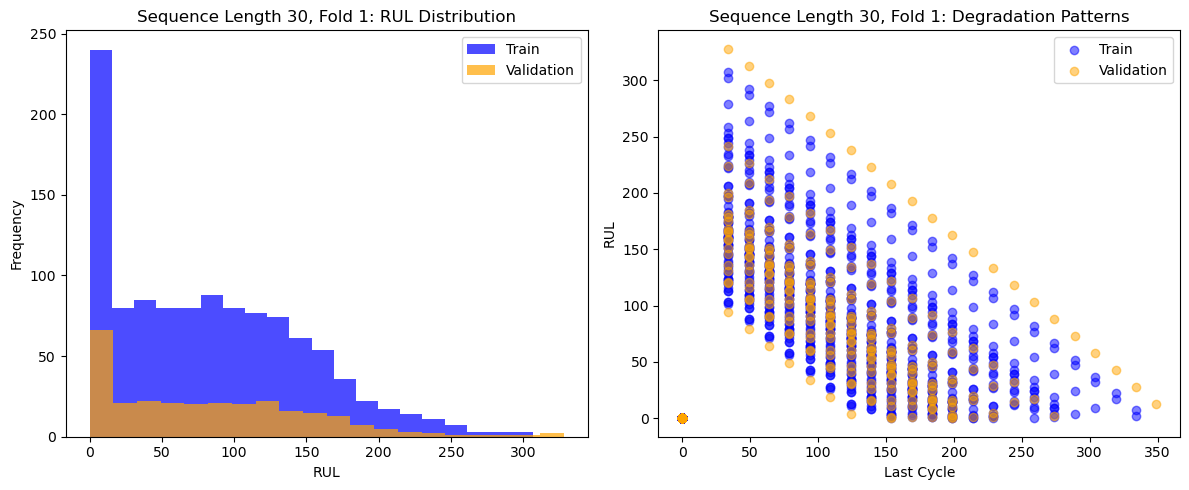

  Fold 2
    Training RUL Statistics:
count    1115.000000
mean       82.260986
std        66.710899
min         0.000000
25%        24.000000
50%        75.000000
75%       129.000000
max       328.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    280.000000
mean      82.364288
std       67.318169
min        0.000000
25%       23.000000
50%       75.500000
75%      128.250000
max      307.000000
Name: RUL, dtype: float64


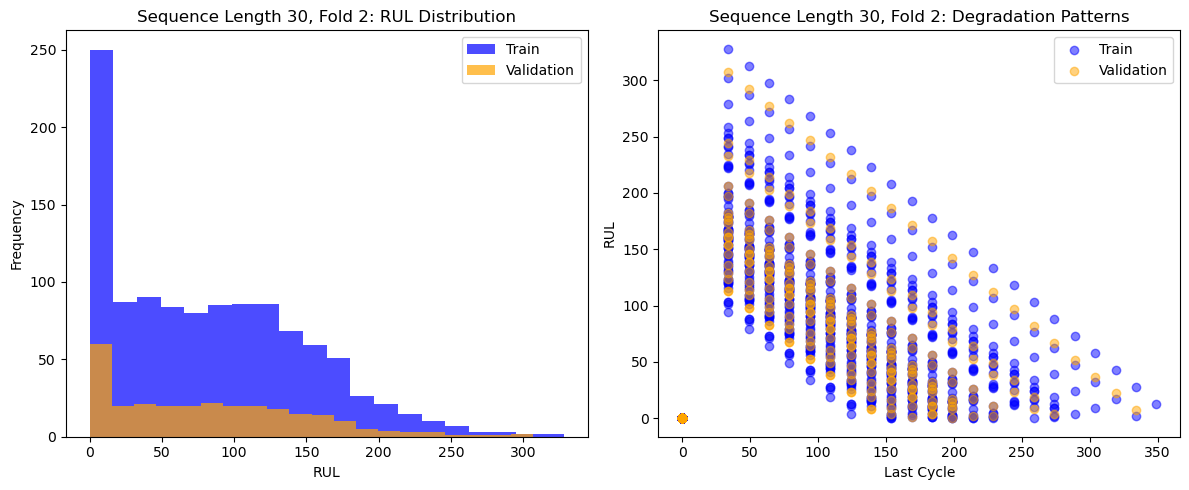

  Fold 3
    Training RUL Statistics:
count    1116.000000
mean       82.276878
std        66.796432
min         0.000000
25%        23.750000
50%        75.000000
75%       129.000000
max       328.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    279.000000
mean      82.301079
std       66.979599
min        0.000000
25%       24.000000
50%       75.000000
75%      129.000000
max      302.000000
Name: RUL, dtype: float64


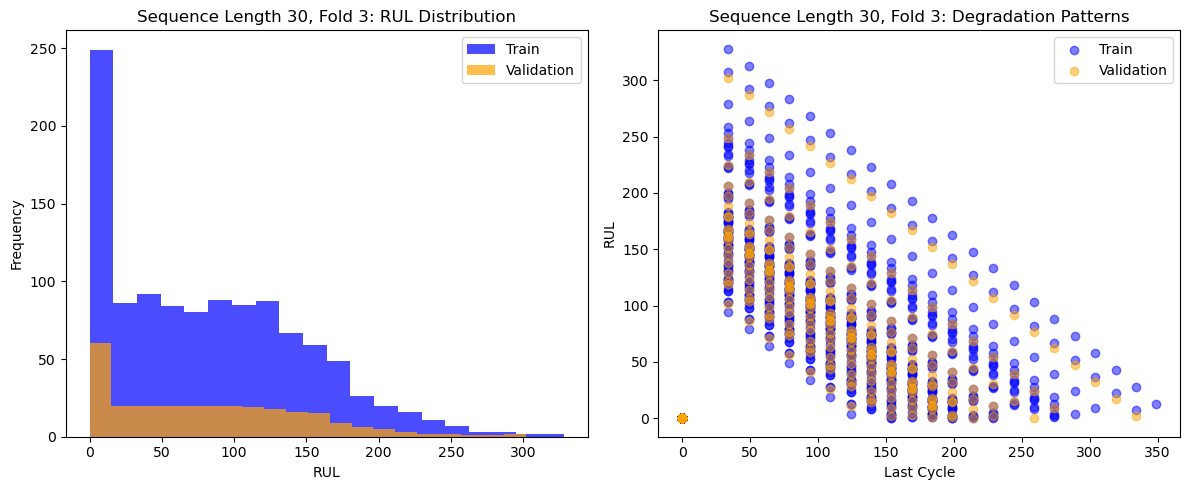

  Fold 4
    Training RUL Statistics:
count    1118.000000
mean       82.229874
std        67.076973
min         0.000000
25%        23.000000
50%        75.000000
75%       129.000000
max       328.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    277.000000
mean      82.490974
std       65.836128
min        0.000000
25%       25.000000
50%       75.000000
75%      130.000000
max      279.000000
Name: RUL, dtype: float64


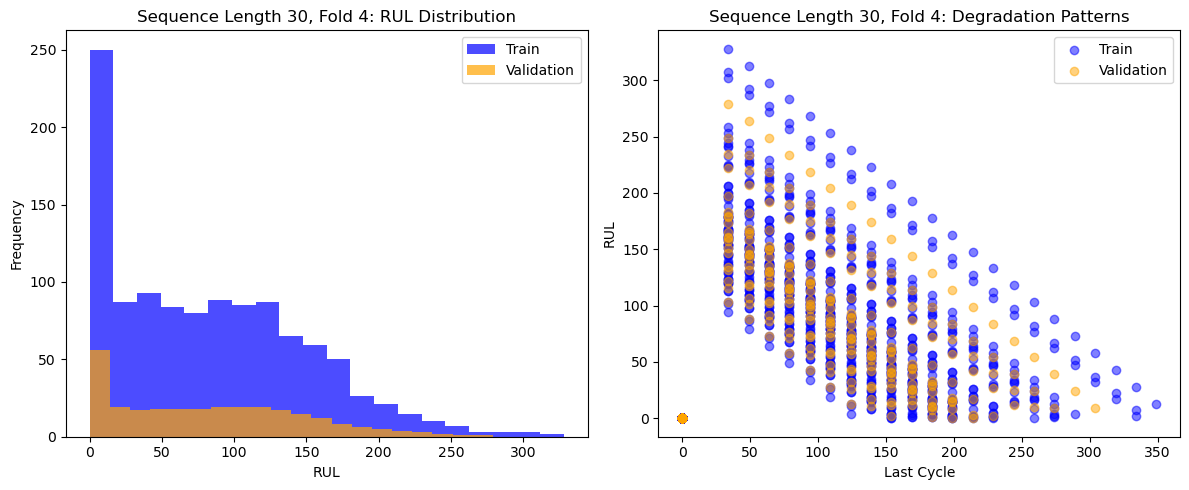

  Fold 5
    Training RUL Statistics:
count    1116.000000
mean       82.420250
std        67.191788
min         0.000000
25%        24.000000
50%        75.000000
75%       129.000000
max       328.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    279.00000
mean      81.72760
std       65.37117
min        0.00000
25%       22.00000
50%       75.00000
75%      127.00000
max      259.00000
Name: RUL, dtype: float64


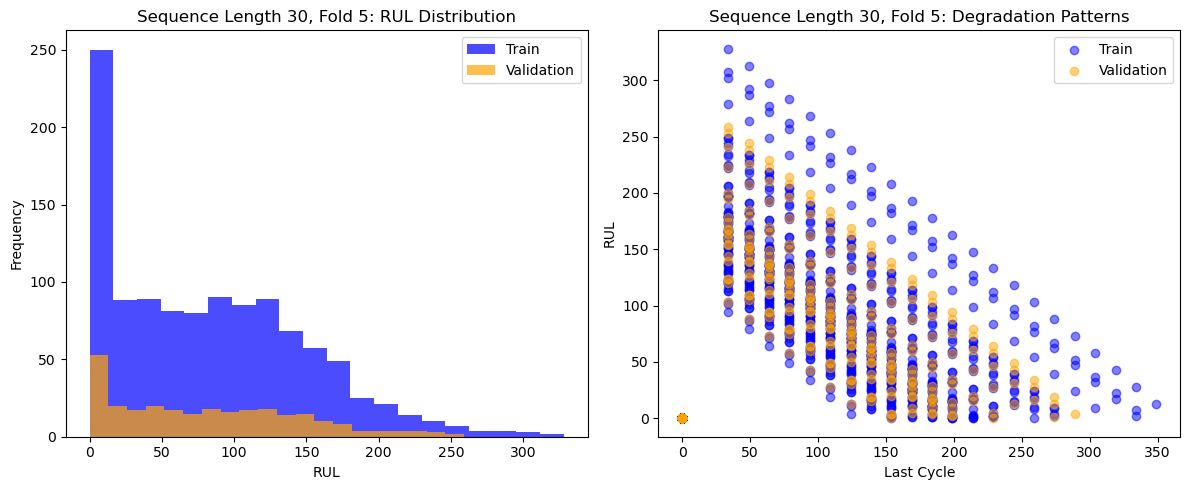

Inspecting Sequence Length 60
  Fold 1
    Training RUL Statistics:
count    580.000000
mean      61.458622
std       61.250488
min        0.000000
25%        0.000000
50%       47.000000
75%      103.000000
max      277.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    145.000000
mean      62.131035
std       63.947479
min        0.000000
25%        0.000000
50%       46.000000
75%      105.000000
max      298.000000
Name: RUL, dtype: float64


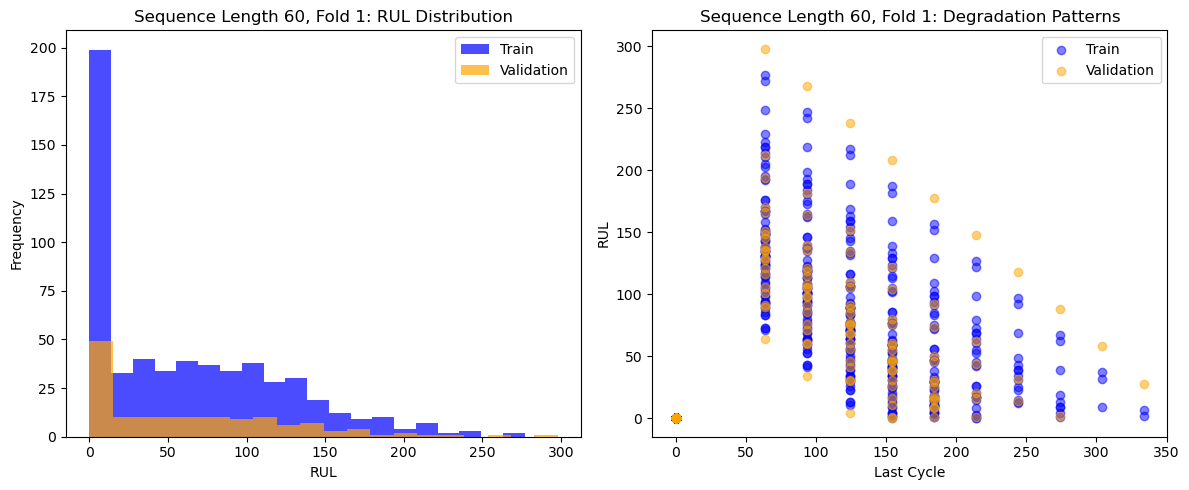

  Fold 2
    Training RUL Statistics:
count    580.000000
mean      61.515518
std       61.659508
min        0.000000
25%        0.000000
50%       47.000000
75%      104.000000
max      298.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    145.000000
mean      61.903450
std       62.348965
min        0.000000
25%        0.000000
50%       53.000000
75%      101.000000
max      277.000000
Name: RUL, dtype: float64


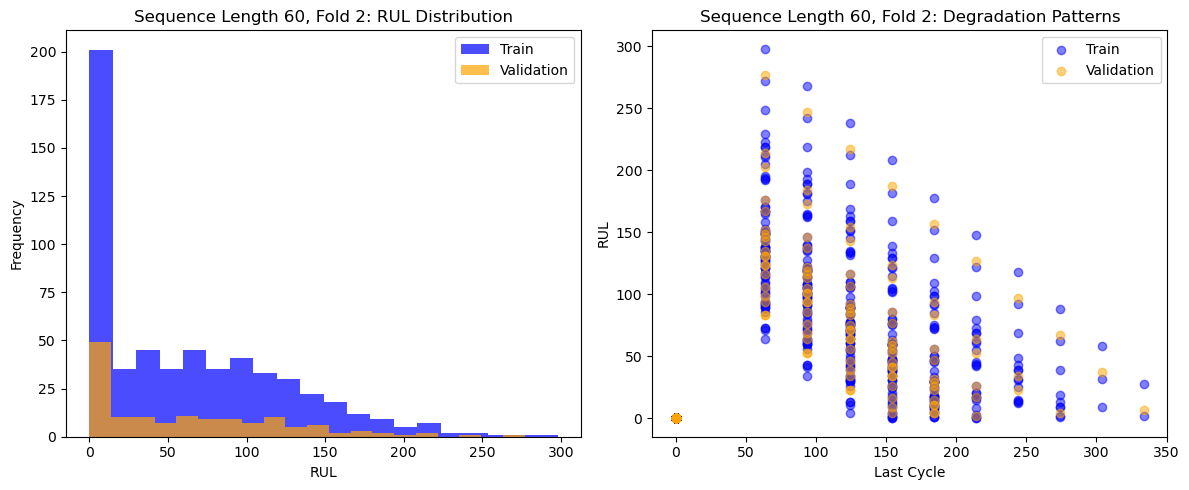

  Fold 3
    Training RUL Statistics:
count    580.000000
mean      61.587933
std       61.747490
min        0.000000
25%        0.000000
50%       47.000000
75%      104.000000
max      298.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    145.000000
mean      61.613792
std       61.998898
min        0.000000
25%        0.000000
50%       47.000000
75%      102.000000
max      272.000000
Name: RUL, dtype: float64


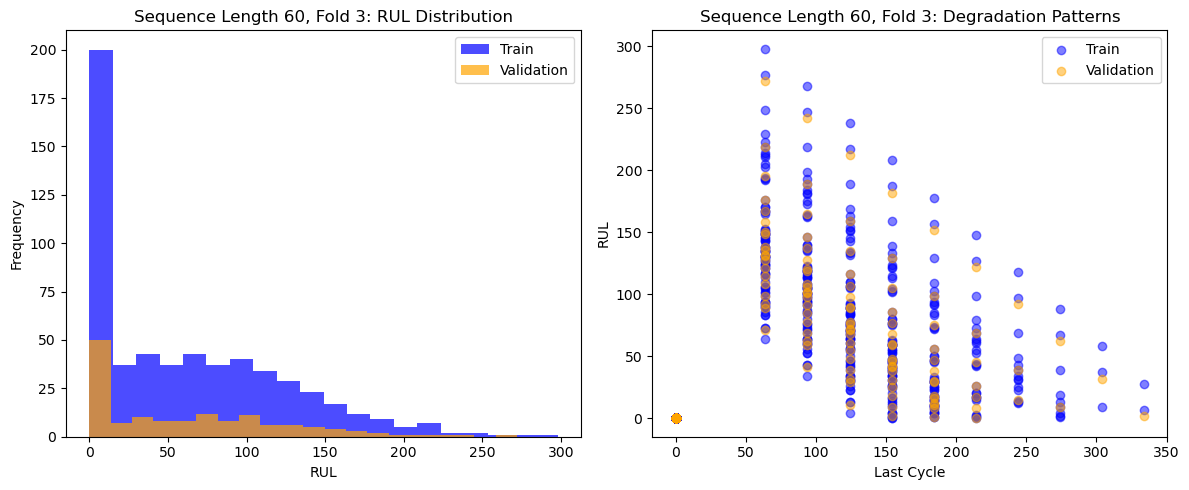

  Fold 4
    Training RUL Statistics:
count    580.000000
mean      61.682758
std       62.006878
min        0.000000
25%        0.000000
50%       47.500000
75%      104.250000
max      298.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    145.000000
mean      61.234482
std       60.947609
min        0.000000
25%        0.000000
50%       45.000000
75%      102.000000
max      249.000000
Name: RUL, dtype: float64


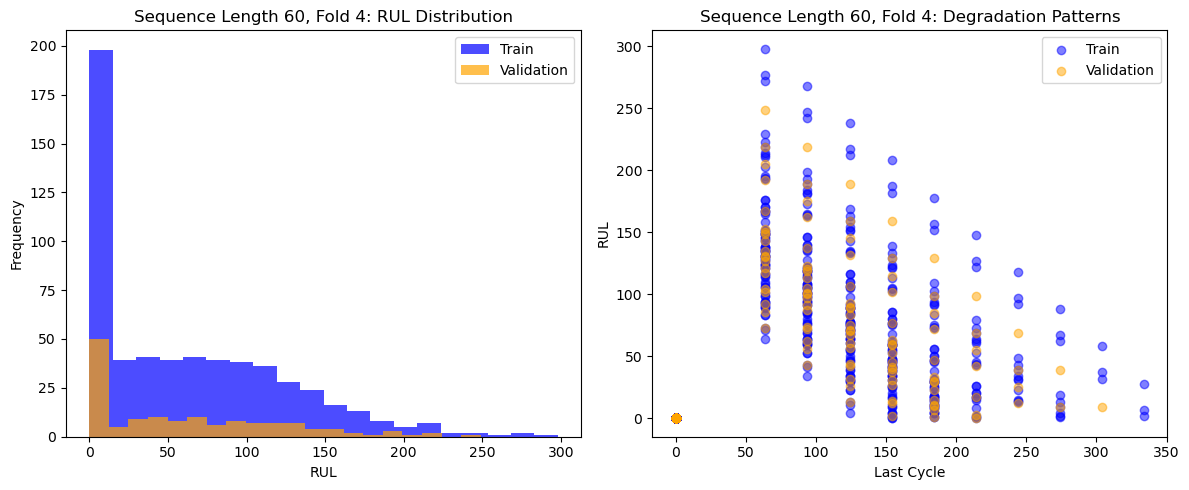

  Fold 5
    Training RUL Statistics:
count    580.000000
mean      61.720688
std       62.159313
min        0.000000
25%        0.000000
50%       47.000000
75%      102.500000
max      298.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    145.000000
mean      61.082760
std       60.318871
min        0.000000
25%        0.000000
50%       48.000000
75%      104.000000
max      229.000000
Name: RUL, dtype: float64


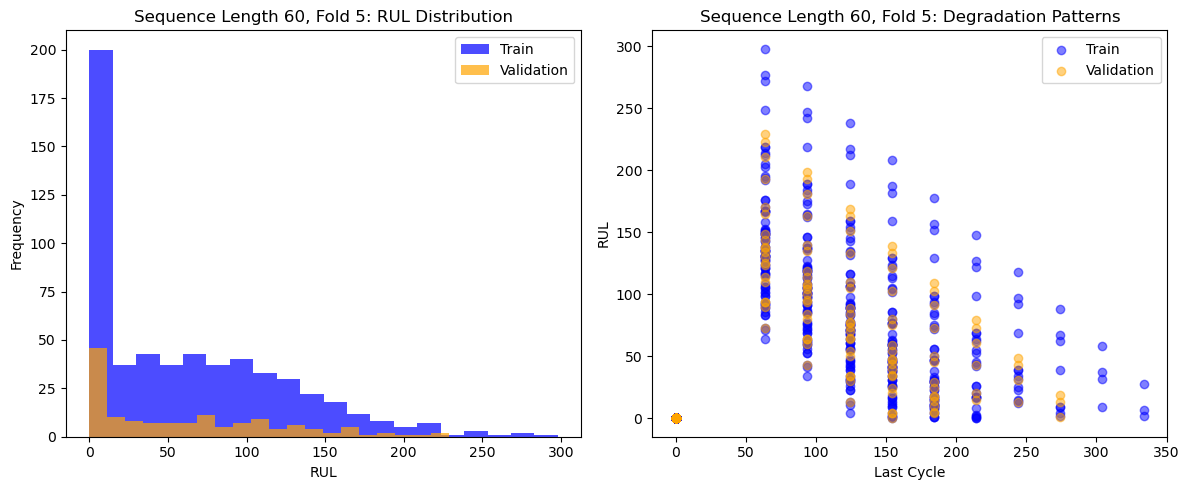

Inspecting Sequence Length 90
  Fold 1
    Training RUL Statistics:
count    404.000000
mean      44.165840
std       53.725624
min        0.000000
25%        0.000000
50%       19.000000
75%       75.250000
max      247.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    101.000000
mean      44.861385
std       56.571018
min        0.000000
25%        0.000000
50%       18.000000
75%       76.000000
max      268.000000
Name: RUL, dtype: float64


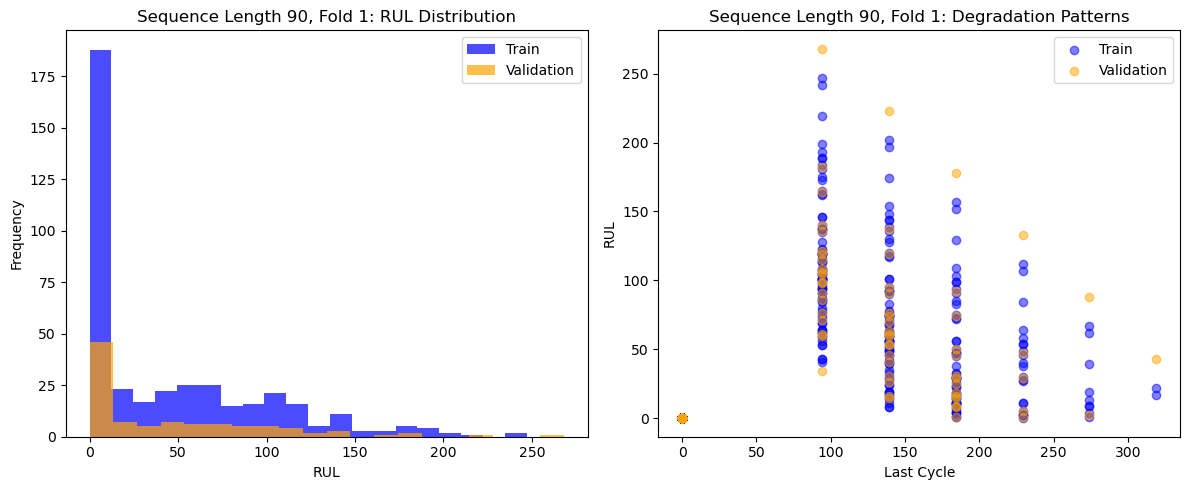

  Fold 2
    Training RUL Statistics:
count    403.000000
mean      44.344913
std       54.173687
min        0.000000
25%        0.000000
50%       18.000000
75%       75.500000
max      268.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    102.000000
mean      44.147060
std       54.818943
min        0.000000
25%        0.000000
50%       20.500000
75%       75.500000
max      247.000000
Name: RUL, dtype: float64


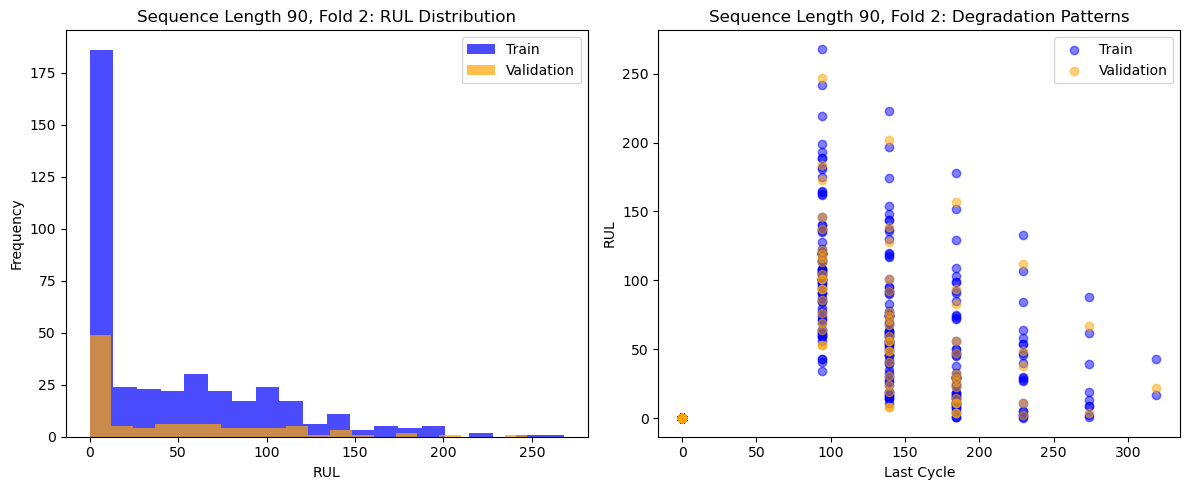

  Fold 3
    Training RUL Statistics:
count    404.000000
mean      44.292080
std       54.250813
min        0.000000
25%        0.000000
50%       19.000000
75%       76.000000
max      268.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    101.000000
mean      44.356434
std       54.517269
min        0.000000
25%        0.000000
50%       17.000000
75%       75.000000
max      242.000000
Name: RUL, dtype: float64


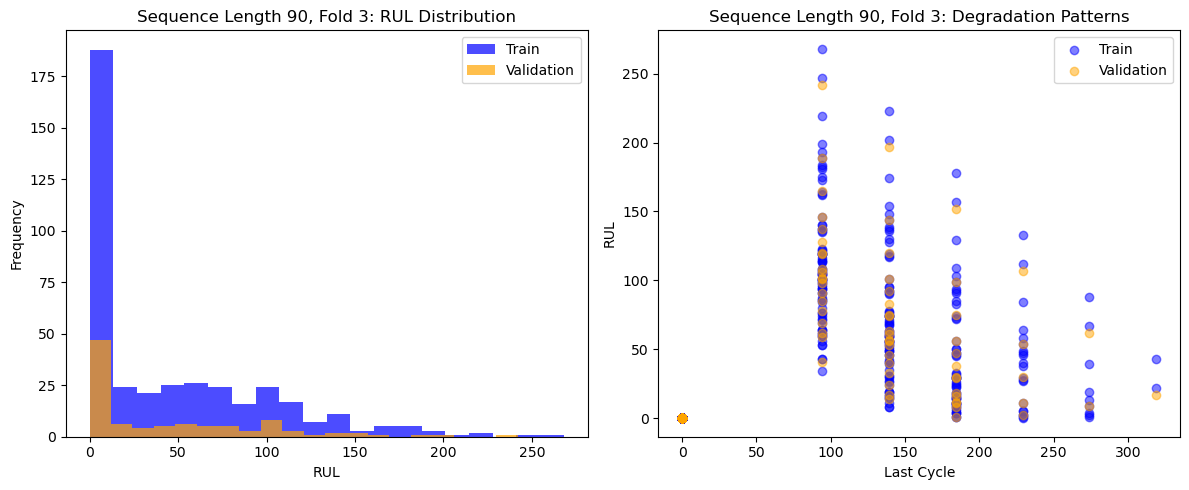

  Fold 4
    Training RUL Statistics:
count    405.000000
mean      44.286419
std       54.488796
min        0.000000
25%        0.000000
50%       18.000000
75%       76.000000
max      268.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    100.000000
mean      44.380001
std       53.542732
min        0.000000
25%        0.000000
50%       25.000000
75%       75.750000
max      219.000000
Name: RUL, dtype: float64


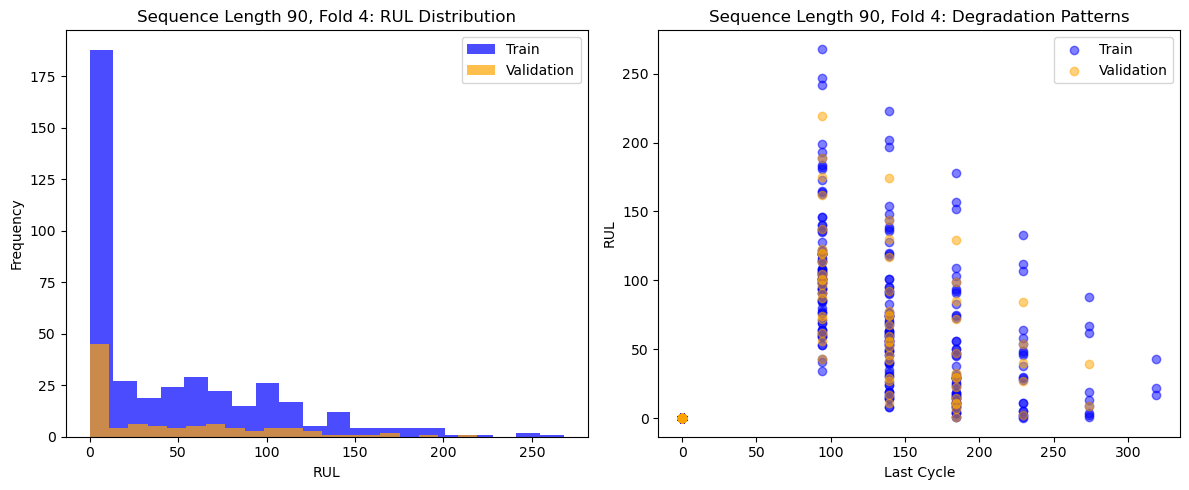

  Fold 5
    Training RUL Statistics:
count    404.000000
mean      44.435642
std       54.672501
min        0.000000
25%        0.000000
50%       18.500000
75%       76.000000
max      268.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count    101.000000
mean      43.782177
std       52.788937
min        0.000000
25%        0.000000
50%       19.000000
75%       74.000000
max      199.000000
Name: RUL, dtype: float64


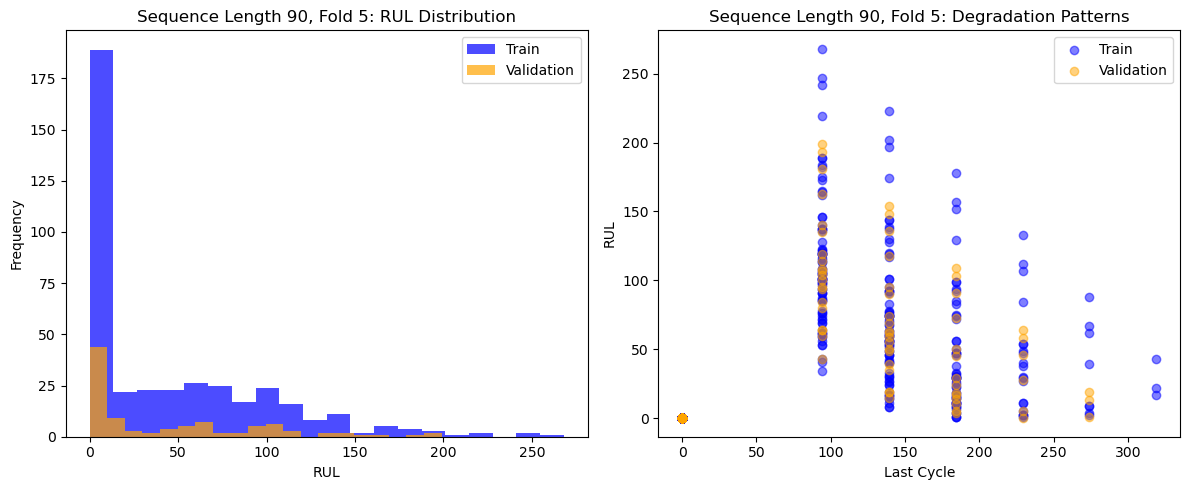

Inspecting Sequence Length 120
  Fold 1
    Training RUL Statistics:
count    313.000000
mean      30.725239
std       45.011841
min        0.000000
25%        0.000000
50%        0.000000
75%       54.000000
max      217.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     78.000000
mean      31.461538
std       48.186245
min        0.000000
25%        0.000000
50%        0.000000
75%       54.500000
max      238.000000
Name: RUL, dtype: float64


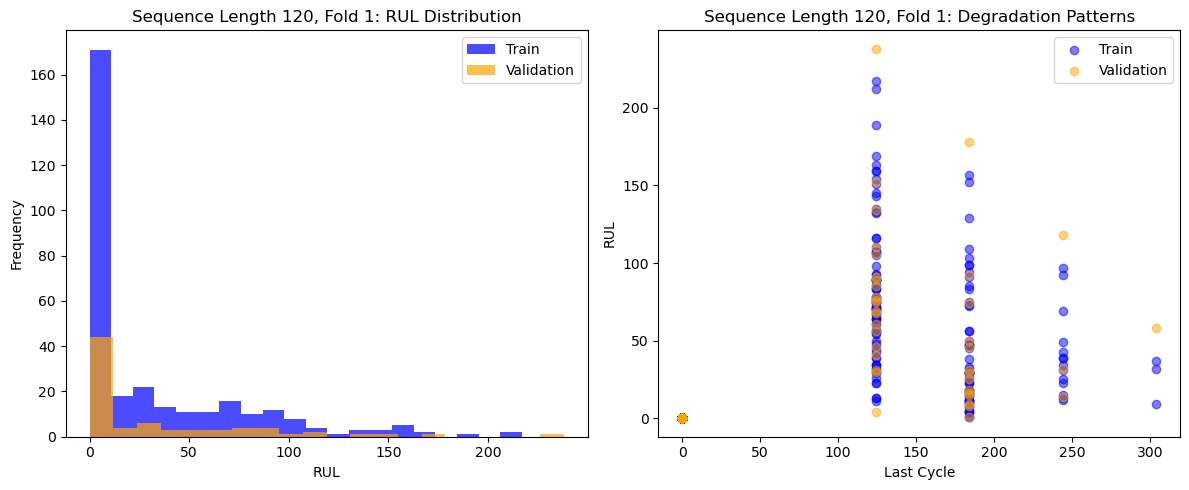

  Fold 2
    Training RUL Statistics:
count    313.000000
mean      30.782747
std       45.487118
min        0.000000
25%        0.000000
50%        0.000000
75%       54.000000
max      238.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     78.000000
mean      31.230770
std       46.345371
min        0.000000
25%        0.000000
50%        0.000000
75%       53.750000
max      217.000000
Name: RUL, dtype: float64


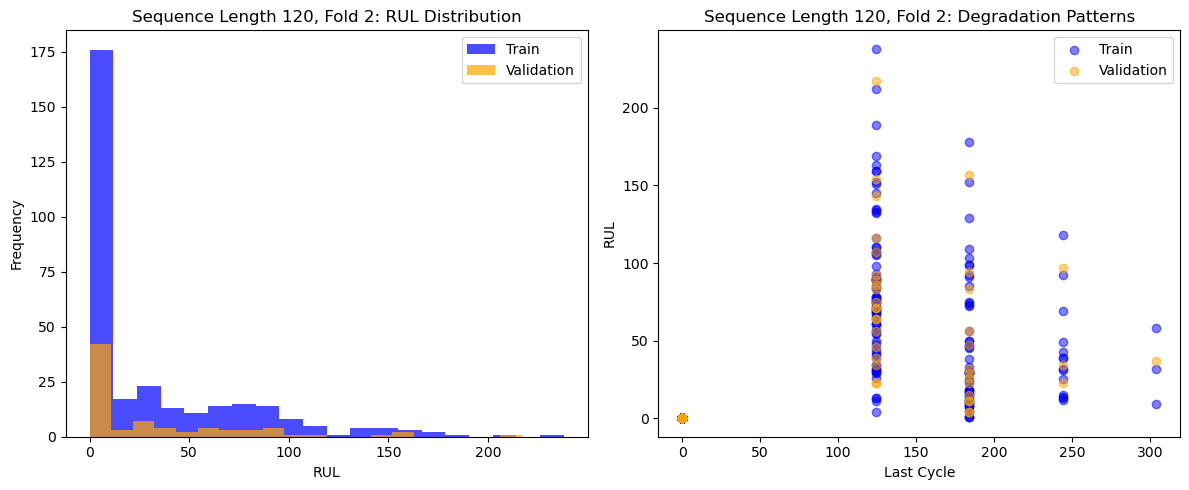

  Fold 3
    Training RUL Statistics:
count    313.000000
mean      30.846645
std       45.585068
min        0.000000
25%        0.000000
50%        0.000000
75%       54.000000
max      238.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     78.00000
mean      30.97436
std       45.95536
min        0.00000
25%        0.00000
50%        0.00000
75%       53.25000
max      212.00000
Name: RUL, dtype: float64


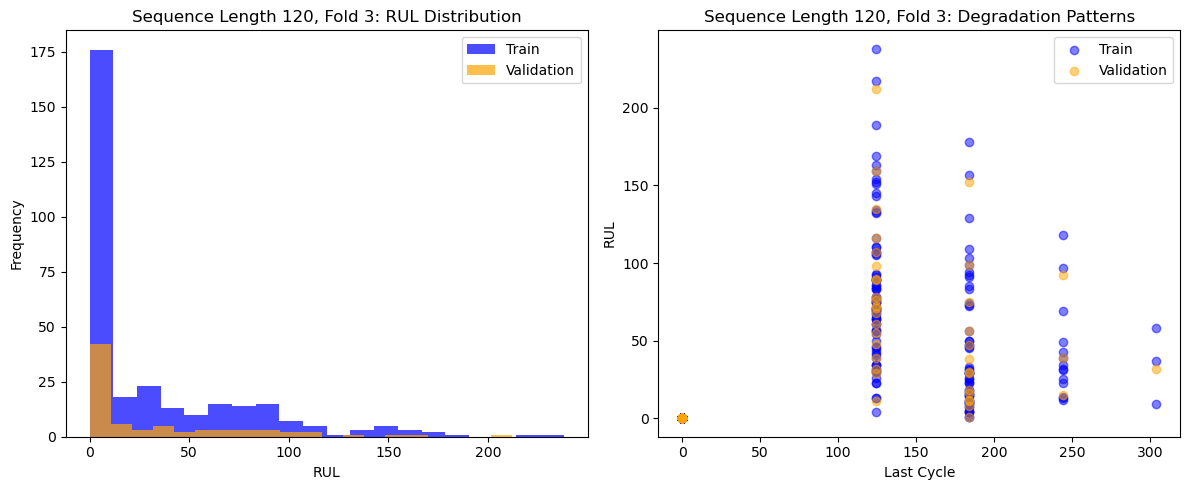

  Fold 4
    Training RUL Statistics:
count    312.000000
mean      31.028847
std       45.931622
min        0.000000
25%        0.000000
50%        0.000000
75%       54.250000
max      238.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     79.000000
mean      30.253164
std       44.548294
min        0.000000
25%        0.000000
50%        0.000000
75%       52.000000
max      189.000000
Name: RUL, dtype: float64


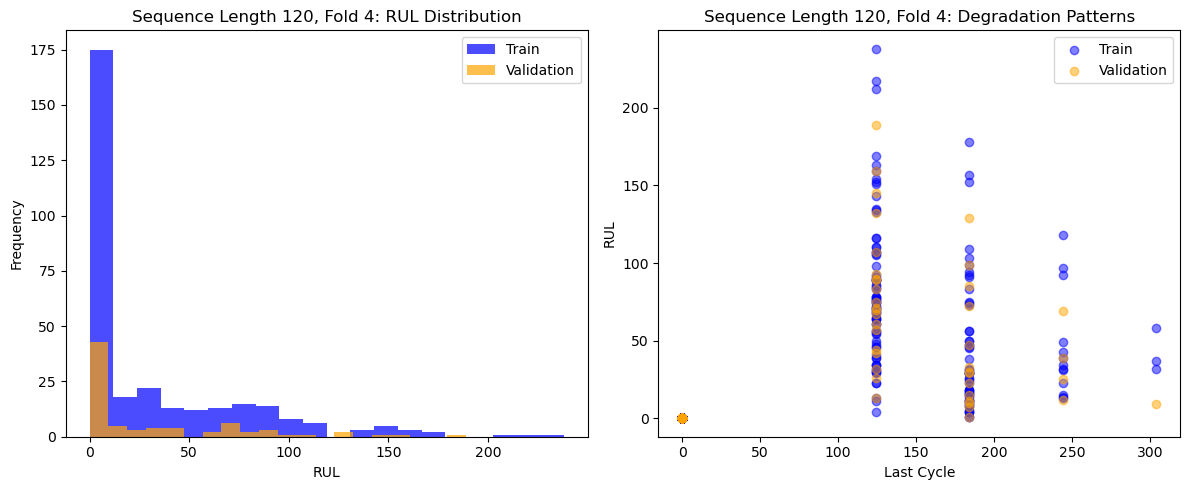

  Fold 5
    Training RUL Statistics:
count    313.000000
mean      30.977636
std       46.050816
min        0.000000
25%        0.000000
50%        0.000000
75%       56.000000
max      238.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     78.000000
mean      30.448717
std       44.031467
min        0.000000
25%        0.000000
50%        0.000000
75%       50.000000
max      169.000000
Name: RUL, dtype: float64


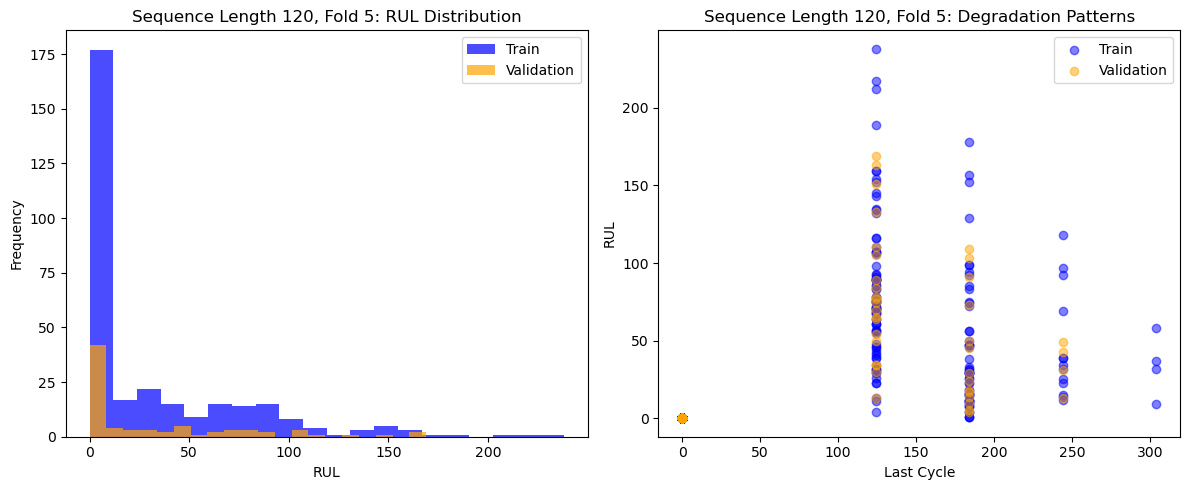

Inspecting Sequence Length 150
  Fold 1
    Training RUL Statistics:
count    245.000000
mean      21.081633
std       36.770809
min        0.000000
25%        0.000000
50%        0.000000
75%       37.000000
max      187.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     62.000000
mean      21.596775
std       40.082481
min        0.000000
25%        0.000000
50%        0.000000
75%       36.250000
max      208.000000
Name: RUL, dtype: float64


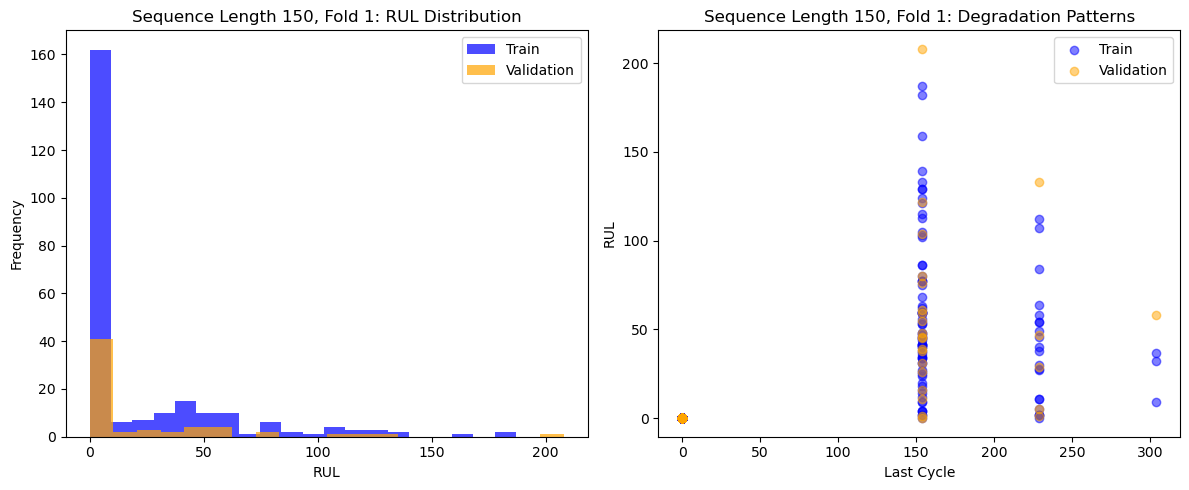

  Fold 2
    Training RUL Statistics:
count    247.000000
mean      21.004049
std       37.200230
min        0.000000
25%        0.000000
50%        0.000000
75%       36.000000
max      208.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     60.000000
mean      21.933332
std       38.500656
min        0.000000
25%        0.000000
50%        0.000000
75%       37.250000
max      187.000000
Name: RUL, dtype: float64


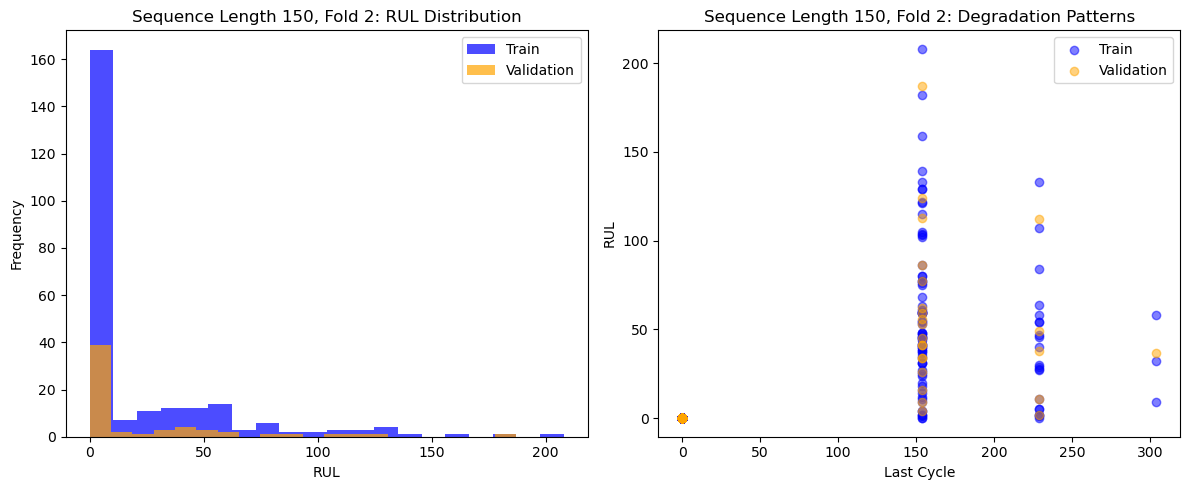

  Fold 3
    Training RUL Statistics:
count    245.000000
mean      21.232653
std       37.423565
min        0.000000
25%        0.000000
50%        0.000000
75%       37.000000
max      208.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     62.000000
mean      21.000000
std       37.590546
min        0.000000
25%        0.000000
50%        0.000000
75%       31.750000
max      182.000000
Name: RUL, dtype: float64


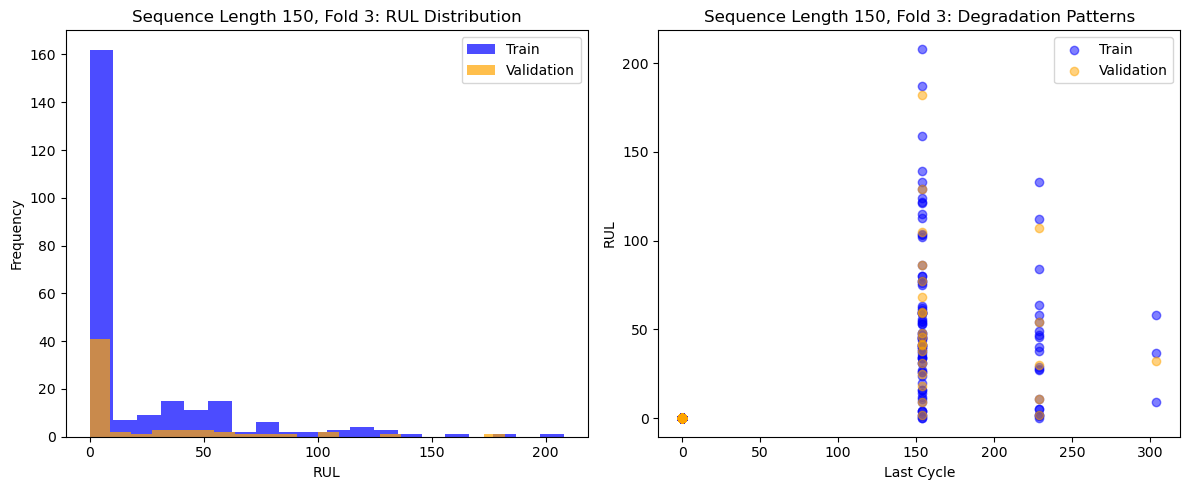

  Fold 4
    Training RUL Statistics:
count    245.000000
mean      21.314285
std       37.764412
min        0.000000
25%        0.000000
50%        0.000000
75%       37.000000
max      208.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     62.000000
mean      20.677420
std       36.197441
min        0.000000
25%        0.000000
50%        0.000000
75%       35.500000
max      159.000000
Name: RUL, dtype: float64


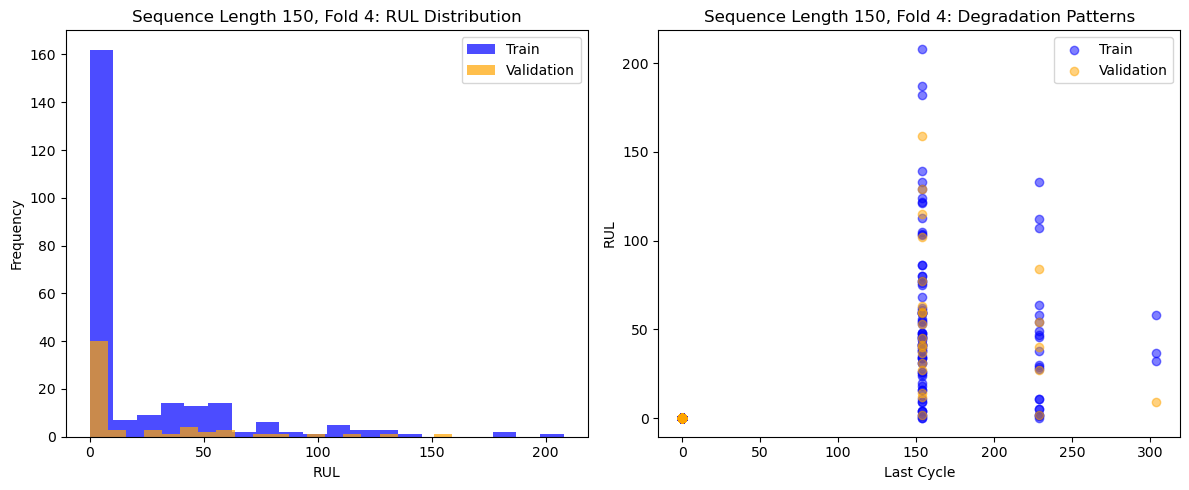

  Fold 5
    Training RUL Statistics:
count    246.000000
mean      21.296747
std       37.884872
min        0.000000
25%        0.000000
50%        0.000000
75%       37.000000
max      208.000000
Name: RUL, dtype: float64
    Validation RUL Statistics:
count     61.000000
mean      20.737705
std       35.653847
min        0.000000
25%        0.000000
50%        0.000000
75%       35.000000
max      139.000000
Name: RUL, dtype: float64


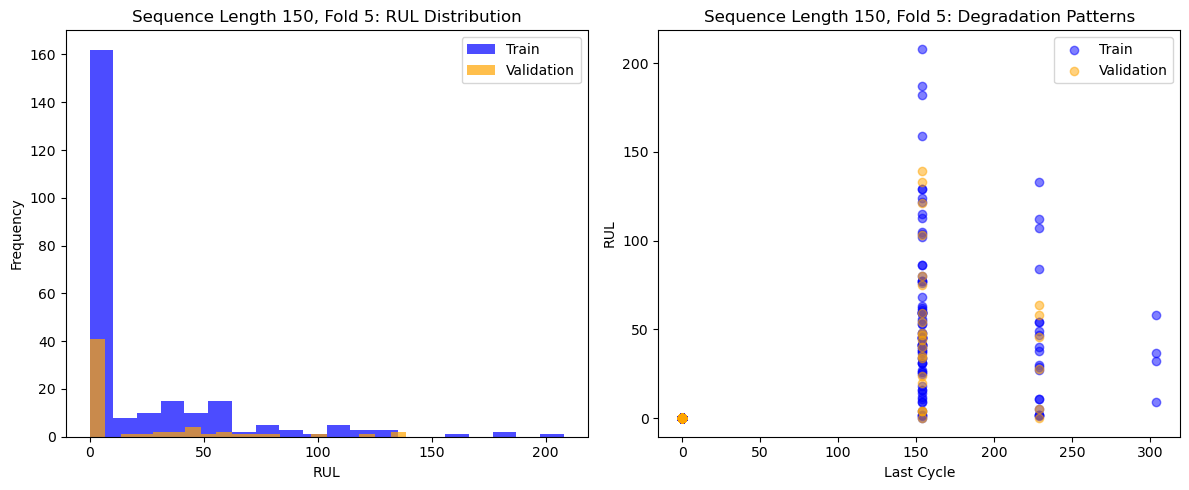

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def inspect_fold_characteristics(loaders_by_sequence_length):
    """
    Inspects and visualizes RUL distribution and degradation patterns for each sequence length.

    Args:
        loaders_by_sequence_length (dict): Dictionary of sequence lengths to (train_loader, val_loader) tuples for k-fold cross-validation.
    """
    for seq_len, (fold_loaders, _) in loaders_by_sequence_length.items():
        print(f"Inspecting Sequence Length {seq_len}")
        for fold, (train_loader, val_loader) in enumerate(fold_loaders):
            print(f"  Fold {fold + 1}")
            
            # Initialize lists to collect RUL and Cycle data
            train_ruls, train_last_cycles = [], []
            val_ruls, val_last_cycles = [], []
            
            # Collect RUL and last cycles for training
            for _, targets, _, _, cycles in train_loader:
                train_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
                last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
                train_last_cycles.extend(last_cycles.tolist())
            
            # Collect RUL and last cycles for validation
            for _, targets, _, _, cycles in val_loader:
                val_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
                last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
                val_last_cycles.extend(last_cycles.tolist())
            
            # Convert to Pandas DataFrames for analysis
            train_df = pd.DataFrame({"RUL": train_ruls, "Last Cycle": train_last_cycles})
            val_df = pd.DataFrame({"RUL": val_ruls, "Last Cycle": val_last_cycles})
            
            # Print summary statistics
            print("    Training RUL Statistics:")
            print(train_df["RUL"].describe())
            print("    Validation RUL Statistics:")
            print(val_df["RUL"].describe())
            
            # Plot RUL distributions
            plt.figure(figsize=(12, 5))
            
            # RUL Distribution
            plt.subplot(1, 2, 1)
            plt.hist(train_df["RUL"], bins=20, alpha=0.7, label="Train", color="blue")
            plt.hist(val_df["RUL"], bins=20, alpha=0.7, label="Validation", color="orange")
            plt.xlabel("RUL")
            plt.ylabel("Frequency")
            plt.title(f"Sequence Length {seq_len}, Fold {fold + 1}: RUL Distribution")
            plt.legend()

            # Degradation Patterns
            plt.subplot(1, 2, 2)
            plt.scatter(train_df["Last Cycle"], train_df["RUL"], alpha=0.5, label="Train", color="blue")
            plt.scatter(val_df["Last Cycle"], val_df["RUL"], alpha=0.5, label="Validation", color="orange")
            plt.xlabel("Last Cycle")
            plt.ylabel("RUL")
            plt.title(f"Sequence Length {seq_len}, Fold {fold + 1}: Degradation Patterns")
            plt.legend()
            
            plt.tight_layout()
            plt.show()

# Inspect the fold characteristics for all sequence lengths
inspect_fold_characteristics(fold_loaders_per_sequence_length)

# Training without K-Fold but using the K-Fold loaders.

In [13]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

from codebase.v8.models import TransformerRULModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = len(tabular_dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_single_run(
    train_loader, val_loader,
    model_config,
    epochs=500,
    lr=0.001,
    weight_decay=1e-6,
    patience=10,
    model_path="saved_weights/model.pth",
    loss_type="mse",  # "mse" or "huber"
):
    """
    Train and validate the model using a *single* train/validation set (no k-fold).
    Summarizes metrics (e.g., RMSE, Avg Loss) for this single train/val split.

    Args:
        fold_loaders (list): List containing a single (train_loader, val_loader) tuple.
        model_config (dict): Configuration for the model (e.g., input_dim, d_model, num_layers).
        epochs (int): Maximum number of epochs to train.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for regularization.
        patience (int): Number of epochs with no improvement before stopping.
        model_path (str): Where to save the best model weights.
        loss_type (str): "mse" or "huber". Determines which loss function is used.

    Returns:
        model (nn.Module): Trained model (best validation loss).
        summary (dict): Summary of metrics for the single train/val run.
    """

    # We'll use only the first tuple from fold_loaders
    
    print("Using standard train/validation approach instead of k-fold.")

    # ======================
    #  Set up model & loss
    # ======================
    model = TransformerRULModel(**model_config).to(device)

    # Choose the loss function based on loss_type
    if loss_type.lower() == "mse":
        criterion = nn.MSELoss()
    elif loss_type.lower() == "huber":
        criterion = nn.HuberLoss(delta=1.0)
    else:
        raise ValueError(f"Invalid loss_type: {loss_type}. Choose 'mse' or 'huber'.")

    # AdamW optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Track metrics for this single run
    fold_metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_rmse": [],
        "val_rmse": [],
    }

    # Early stopping variables
    best_val_loss = float("inf")
    best_epoch = 0
    epochs_no_improve = 0
    early_stop = False

    # ======================
    #  Training Loop
    # ======================
    total_batches = len(train_loader) * epochs
    with tqdm(total=total_batches, desc="Training", unit="batch") as pbar:
        for epoch in range(epochs):
            if early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break

            # ---------------------------
            # 1. Training
            # ---------------------------
            model.train()
            train_loss_accum = 0.0
            train_predictions = []
            train_targets_all = []

            for inputs, targets, masks, _, _ in train_loader:
                optimizer.zero_grad()

                inputs = inputs.to(device)
                targets = targets.to(device)
                masks = masks.to(device)

                outputs = model(inputs, masks)  # (batch_size,)

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                # Accumulate for final averaging
                batch_size = inputs.size(0)
                train_loss_accum += loss.item() * batch_size

                # For RMSE calculation, store predictions & targets
                train_predictions.append(outputs.detach().cpu())
                train_targets_all.append(targets.detach().cpu())

                pbar.update(1)

            # Compute average training loss
            num_train_samples = len(train_loader.dataset)
            avg_train_loss = train_loss_accum / num_train_samples

            # Compute training RMSE
            train_predictions = torch.cat(train_predictions, dim=0)
            train_targets_all = torch.cat(train_targets_all, dim=0)
            train_rmse = torch.sqrt(torch.mean((train_predictions - train_targets_all) ** 2)).item()

            # ---------------------------
            # 2. Validation
            # ---------------------------
            model.eval()
            val_loss_accum = 0.0
            val_predictions = []
            val_targets_all = []

            with torch.no_grad():
                for inputs, targets, masks, _, _ in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    masks = masks.to(device)

                    outputs = model(inputs, masks)
                    loss = criterion(outputs, targets)

                    batch_size = inputs.size(0)
                    val_loss_accum += loss.item() * batch_size

                    val_predictions.append(outputs.cpu())
                    val_targets_all.append(targets.cpu())

            num_val_samples = len(val_loader.dataset)
            avg_val_loss = val_loss_accum / num_val_samples

            val_predictions = torch.cat(val_predictions, dim=0)
            val_targets_all = torch.cat(val_targets_all, dim=0)
            val_rmse = torch.sqrt(torch.mean((val_predictions - val_targets_all) ** 2)).item()

            # ---------------------------
            # 3. Early Stopping Logic
            # ---------------------------
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_val_rmse = val_rmse

                epochs_no_improve = 0
                best_epoch = epoch + 1
                torch.save(model.state_dict(), model_path)
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                early_stop = True

            # Record stats
            fold_metrics["train_loss"].append(avg_train_loss)
            fold_metrics["val_loss"].append(avg_val_loss)
            fold_metrics["train_rmse"].append(train_rmse)
            fold_metrics["val_rmse"].append(val_rmse)

            # ---------------------------
            # 4. TQDM Logging
            # ---------------------------
            pbar.set_postfix({
                "Epoch": f"{epoch + 1}/{epochs}",
                "Train Loss": f"{avg_train_loss:.4f}",
                "Train RMSE": f"{train_rmse:.4f}",
                "Val Loss": f"{avg_val_loss:.4f}",
                "Val RMSE": f"{val_rmse:.4f}"
            })
            pbar.update(0)

    # ======================
    #  Final Summary
    # ======================
    # Load best model
    model.load_state_dict(torch.load(model_path))

    # Summaries
    summary = {
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "best_val_rmse": best_val_rmse,
        "final_train_loss": fold_metrics["train_loss"][-1] if fold_metrics["train_loss"] else None,
        "final_val_loss": fold_metrics["val_loss"][-1] if fold_metrics["val_loss"] else None,
        "final_train_rmse": fold_metrics["train_rmse"][-1] if fold_metrics["train_rmse"] else None,
        "final_val_rmse": fold_metrics["val_rmse"][-1] if fold_metrics["val_rmse"] else None,
    }

    print("\n--- Train/Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value}")

    print(f"\nTraining complete. Best model loaded (epoch {best_epoch}).")

    return model, summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training hyperparameter search: Optuna

In [ ]:
import optuna

def objective(trial, train_loader, val_loader):
    """
    Objective function for Optuna hyperparameter optimization for a specific sequence length.
    """
    # Ensure transformer_d_model is divisible by transformer_nhead
    nhead = trial.suggest_int("nhead", 2, 8, step=2)
    d_model = trial.suggest_int(
        "d_model", nhead * 16, nhead * 32, step=nhead * 8
    )
    
    dim_feedforward = trial.suggest_int("dim_feedforward", 128, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Define model configuration
    model_config = {
        "input_dim": input_dim,
        "d_model": d_model,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_feedforward,
        "dropout": dropout,
    }

    # Train and validate using the provided loaders
    _, summary = train_and_validate_single_run(
        train_loader=train_loader,
        val_loader=val_loader,
        model_config=model_config,
        epochs=50,  # Fewer epochs for faster tuning
        lr=lr,
        weight_decay=weight_decay,
        patience=10  # Early stopping patience
    )

    # Return the mean validation RMSE as the objective value
    return summary["final_val_rmse"]

# Dictionary to store best hyperparameters and results for each sequence length
best_results_by_sequence_length = {}

# train only sequence lentgh 150 this time
#fold_loaders = {150: fold_loaders_per_sequence_length[150]}

# Iterate over all sequence lengths
for sequence_length, (fold_loaders, _) in fold_loaders.items():
    print(f"Optimizing hyperparameters for sequence length {sequence_length}...")

    # Use the first fold for simplicity; modify to support all folds if needed
    train_loader, val_loader = fold_loaders[0]

    # Create a study for this sequence length
    study = optuna.create_study(direction="minimize")  # Minimize RMSE
    study.optimize(
        lambda trial: objective(trial, train_loader, val_loader), 
        n_trials=50  # Number of trials for hyperparameter tuning
    )

    # Store the best results
    best_results_by_sequence_length[sequence_length] = {
        "best_params": study.best_params,
        "best_val_rmse": study.best_value
    }

    # Print results for this sequence length
    print(f"Best hyperparameters for sequence length {sequence_length}: {study.best_params}")
    print(f"Best validation RMSE for sequence length {sequence_length}: {study.best_value:.4f}")

# Summary of all results
print("\n--- Hyperparameter Optimization Summary ---")
for seq_len, results in best_results_by_sequence_length.items():
    print(f"Sequence Length {seq_len}:")
    print(f"  Best Hyperparameters: {results['best_params']}")
    print(f"  Best Validation RMSE: {results['best_val_rmse']:.4f}")


[I 2025-01-21 15:38:45,932] A new study created in memory with name: no-name-a7a42366-6e78-4f25-b792-00d1412f2ef2


Optimizing hyperparameters for sequence length 150...
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

/home/oliver/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327489/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
/tmp/ipykernel_55333/4077367312.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explic


--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1613.854248046875
best_val_rmse: 40.17280578613281
final_train_loss: 1390.124755859375
final_val_loss: 1613.854248046875
final_train_rmse: 37.28438186645508
final_val_rmse: 40.17280578613281

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:41:10,436] Trial 1 finished with value: 41.16173553466797 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 448, 'num_layers': 4, 'dropout': 0.14042655122735198, 'lr': 0.0002536094834711464, 'weight_decay': 1.7653217663370894e-05}. Best is trial 0 with value: 40.17280578613281.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1694.2884521484375
best_val_rmse: 41.16173553466797
final_train_loss: 1459.54248046875
final_val_loss: 1694.2884521484375
final_train_rmse: 38.20396041870117
final_val_rmse: 41.16173553466797

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:42:15,668] Trial 2 finished with value: 37.40726852416992 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 3, 'dropout': 0.27438721787160725, 'lr': 0.00039828462684158704, 'weight_decay': 5.50192895789913e-05}. Best is trial 2 with value: 37.40726852416992.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1399.3035888671875
best_val_rmse: 37.40726852416992
final_train_loss: 1195.3712158203125
final_val_loss: 1399.3035888671875
final_train_rmse: 34.57414627075195
final_val_rmse: 37.40726852416992

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:43:18,660] Trial 3 finished with value: 31.792911529541016 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.35047075854220433, 'lr': 0.0010116413825915862, 'weight_decay': 8.176246459822326e-05}. Best is trial 3 with value: 31.792911529541016.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1010.789306640625
best_val_rmse: 31.792911529541016
final_train_loss: 879.7979125976562
final_val_loss: 1010.789306640625
final_train_rmse: 29.661388397216797
final_val_rmse: 31.792911529541016

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:44:27,154] Trial 4 finished with value: 43.66915512084961 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 192, 'num_layers': 4, 'dropout': 0.2953534490570874, 'lr': 0.00017118415395548818, 'weight_decay': 1.228790445663897e-06}. Best is trial 3 with value: 31.792911529541016.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1906.9951171875
best_val_rmse: 43.66915512084961
final_train_loss: 1666.020263671875
final_val_loss: 1906.9951171875
final_train_rmse: 40.81690979003906
final_val_rmse: 43.66915512084961

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:45:35,910] Trial 5 finished with value: 43.68345260620117 and parameters: {'nhead': 2, 'd_model': 64, 'dim_feedforward': 448, 'num_layers': 4, 'dropout': 0.15959393292399837, 'lr': 0.00035887531173860583, 'weight_decay': 3.807223657063639e-06}. Best is trial 3 with value: 31.792911529541016.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1908.2440185546875
best_val_rmse: 43.68345260620117
final_train_loss: 1665.427490234375
final_val_loss: 1908.2440185546875
final_train_rmse: 40.80964660644531
final_val_rmse: 43.68345260620117

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:46:47,865] Trial 6 finished with value: 43.273895263671875 and parameters: {'nhead': 4, 'd_model': 64, 'dim_feedforward': 384, 'num_layers': 2, 'dropout': 0.41408890678879373, 'lr': 0.000719525090206042, 'weight_decay': 2.016963618033942e-06}. Best is trial 3 with value: 31.792911529541016.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1872.6297607421875
best_val_rmse: 43.273895263671875
final_train_loss: 1639.7091064453125
final_val_loss: 1872.6297607421875
final_train_rmse: 40.493324279785156
final_val_rmse: 43.273895263671875

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:48:01,247] Trial 7 finished with value: 41.4904899597168 and parameters: {'nhead': 4, 'd_model': 96, 'dim_feedforward': 384, 'num_layers': 2, 'dropout': 0.10174526680890206, 'lr': 0.00047534567692031826, 'weight_decay': 6.149355462386444e-06}. Best is trial 3 with value: 31.792911529541016.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1721.4609375
best_val_rmse: 41.4904899597168
final_train_loss: 1487.5650634765625
final_val_loss: 1721.4609375
final_train_rmse: 38.568965911865234
final_val_rmse: 41.4904899597168

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:48:42,554] Trial 8 finished with value: 19.47114372253418 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.4176079938150751, 'lr': 0.007042227449305538, 'weight_decay': 1.4184176006864341e-05}. Best is trial 8 with value: 19.47114372253418.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 31

--- Train/Validation Summary ---
best_epoch: 20
best_val_loss: 221.61012268066406
best_val_rmse: 14.886576652526855
final_train_loss: 91.51033020019531
final_val_loss: 379.1254577636719
final_train_rmse: 9.566102981567383
final_val_rmse: 19.47114372253418

Training complete. Best model loaded (epoch 20).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 15:49:53,004] Trial 9 finished with value: 44.616424560546875 and parameters: {'nhead': 2, 'd_model': 32, 'dim_feedforward': 192, 'num_layers': 3, 'dropout': 0.11590844924448405, 'lr': 0.0002886973362995303, 'weight_decay': 6.712359218762397e-05}. Best is trial 8 with value: 19.47114372253418.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1990.62548828125
best_val_rmse: 44.616424560546875
final_train_loss: 1740.0035400390625
final_val_loss: 1990.62548828125
final_train_rmse: 41.713348388671875
final_val_rmse: 44.616424560546875

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:50:26,289] Trial 10 finished with value: 23.777984619140625 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.49155115985323194, 'lr': 0.009581340016791734, 'weight_decay': 1.797677986847821e-05}. Best is trial 8 with value: 19.47114372253418.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 24

--- Train/Validation Summary ---
best_epoch: 13
best_val_loss: 334.1285400390625
best_val_rmse: 18.27918243408203
final_train_loss: 488.71649169921875
final_val_loss: 565.3925170898438
final_train_rmse: 22.10693359375
final_val_rmse: 23.777984619140625

Training complete. Best model loaded (epoch 13).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:51:11,222] Trial 11 finished with value: 21.4575252532959 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.4948565556918061, 'lr': 0.00991511148838034, 'weight_decay': 1.8025837291625005e-05}. Best is trial 8 with value: 19.47114372253418.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 34

--- Train/Validation Summary ---
best_epoch: 23
best_val_loss: 172.6527557373047
best_val_rmse: 13.139739990234375
final_train_loss: 90.45014190673828
final_val_loss: 460.4253234863281
final_train_rmse: 9.510527610778809
final_val_rmse: 21.4575252532959

Training complete. Best model loaded (epoch 23).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:51:56,241] Trial 12 finished with value: 24.081247329711914 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.49878359502722897, 'lr': 0.009658762265389928, 'weight_decay': 1.990029007476229e-05}. Best is trial 8 with value: 19.47114372253418.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 32

--- Train/Validation Summary ---
best_epoch: 21
best_val_loss: 205.4162139892578
best_val_rmse: 14.332348823547363
final_train_loss: 130.28045654296875
final_val_loss: 579.906494140625
final_train_rmse: 11.414047241210938
final_val_rmse: 24.081247329711914

Training complete. Best model loaded (epoch 21).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:52:40,686] Trial 13 finished with value: 16.014541625976562 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.42138668484649366, 'lr': 0.003645034316270976, 'weight_decay': 9.801627747746783e-06}. Best is trial 13 with value: 16.014541625976562.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 33

--- Train/Validation Summary ---
best_epoch: 22
best_val_loss: 177.17678833007812
best_val_rmse: 13.310776710510254
final_train_loss: 48.577178955078125
final_val_loss: 256.4655456542969
final_train_rmse: 6.969732761383057
final_val_rmse: 16.014541625976562

Training complete. Best model loaded (epoch 22).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:53:26,734] Trial 14 finished with value: 14.724321365356445 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.39847528773158986, 'lr': 0.0032932451047700427, 'weight_decay': 8.056674338446418e-06}. Best is trial 14 with value: 14.724321365356445.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 35

--- Train/Validation Summary ---
best_epoch: 24
best_val_loss: 177.90032958984375
best_val_rmse: 13.337928771972656
final_train_loss: 65.24756622314453
final_val_loss: 216.80563354492188
final_train_rmse: 8.077596664428711
final_val_rmse: 14.724321365356445

Training complete. Best model loaded (epoch 24).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:54:17,054] Trial 15 finished with value: 30.02142333984375 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 384, 'num_layers': 2, 'dropout': 0.38620507507848495, 'lr': 0.0032406475735472116, 'weight_decay': 8.165655547200385e-06}. Best is trial 14 with value: 14.724321365356445.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38

--- Train/Validation Summary ---
best_epoch: 27
best_val_loss: 320.05560302734375
best_val_rmse: 17.89009666442871
final_train_loss: 133.5699005126953
final_val_loss: 901.2858276367188
final_train_rmse: 11.557245254516602
final_val_rmse: 30.02142333984375

Training complete. Best model loaded (epoch 27).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:55:19,993] Trial 16 finished with value: 16.42832374572754 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 320, 'num_layers': 1, 'dropout': 0.23833182262273125, 'lr': 0.002316145381823415, 'weight_decay': 4.3430062977654315e-06}. Best is trial 14 with value: 14.724321365356445.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 46

--- Train/Validation Summary ---
best_epoch: 35
best_val_loss: 172.87765502929688
best_val_rmse: 13.148293495178223
final_train_loss: 53.79817199707031
final_val_loss: 269.8898620605469
final_train_rmse: 7.334723949432373
final_val_rmse: 16.42832374572754

Training complete. Best model loaded (epoch 35).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:56:10,973] Trial 17 finished with value: 21.036378860473633 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 448, 'num_layers': 1, 'dropout': 0.3617248711455273, 'lr': 0.003255016143299234, 'weight_decay': 3.9888496184192815e-05}. Best is trial 14 with value: 14.724321365356445.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38

--- Train/Validation Summary ---
best_epoch: 27
best_val_loss: 196.80946350097656
best_val_rmse: 14.02888011932373
final_train_loss: 97.20072174072266
final_val_loss: 442.52923583984375
final_train_rmse: 9.859042167663574
final_val_rmse: 21.036378860473633

Training complete. Best model loaded (epoch 27).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).


[I 2025-01-21 15:57:24,400] Trial 18 finished with value: 16.64291000366211 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 320, 'num_layers': 3, 'dropout': 0.43541483729511854, 'lr': 0.001717881793156797, 'weight_decay': 3.224541793841831e-05}. Best is trial 14 with value: 14.724321365356445.


No improvement for 6 epoch(s).

--- Train/Validation Summary ---
best_epoch: 44
best_val_loss: 229.57757568359375
best_val_rmse: 15.15181827545166
final_train_loss: 94.44189453125
final_val_loss: 276.98638916015625
final_train_rmse: 9.718122482299805
final_val_rmse: 16.64291000366211

Training complete. Best model loaded (epoch 44).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 15:58:21,102] Trial 19 finished with value: 26.071319580078125 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 320, 'num_layers': 2, 'dropout': 0.32914992817261013, 'lr': 0.00468115497233262, 'weight_decay': 2.9148517596084363e-06}. Best is trial 14 with value: 14.724321365356445.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 41

--- Train/Validation Summary ---
best_epoch: 30
best_val_loss: 244.11148071289062
best_val_rmse: 15.624067306518555
final_train_loss: 189.8617706298828
final_val_loss: 679.7136840820312
final_train_rmse: 13.779033660888672
final_val_rmse: 26.071319580078125

Training complete. Best model loaded (epoch 30).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).


[I 2025-01-21 15:59:31,649] Trial 20 finished with value: 18.98492431640625 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 448, 'num_layers': 1, 'dropout': 0.4513574091350145, 'lr': 0.001252606422000778, 'weight_decay': 9.754702042427325e-06}. Best is trial 14 with value: 14.724321365356445.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
best_epoch: 48
best_val_loss: 333.16253662109375
best_val_rmse: 18.25274085998535
final_train_loss: 204.6643524169922
final_val_loss: 360.4272766113281
final_train_rmse: 14.306095123291016
final_val_rmse: 18.98492431640625

Training complete. Best model loaded (epoch 48).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).


[I 2025-01-21 16:00:40,721] Trial 21 finished with value: 13.116156578063965 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 320, 'num_layers': 1, 'dropout': 0.20953837933005257, 'lr': 0.0021879798620473437, 'weight_decay': 5.1956341006182336e-06}. Best is trial 21 with value: 13.116156578063965.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 172.03353881835938
best_val_rmse: 13.116156578063965
final_train_loss: 37.76596450805664
final_val_loss: 172.03353881835938
final_train_rmse: 6.145402431488037
final_val_rmse: 13.116156578063965

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:01:24,243] Trial 22 finished with value: 14.632560729980469 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.19926653548965195, 'lr': 0.004407873058204051, 'weight_decay': 6.4338034682662746e-06}. Best is trial 21 with value: 13.116156578063965.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 33

--- Train/Validation Summary ---
best_epoch: 22
best_val_loss: 166.29942321777344
best_val_rmse: 12.895713806152344
final_train_loss: 34.56594467163086
final_val_loss: 214.11184692382812
final_train_rmse: 5.879281520843506
final_val_rmse: 14.632560729980469

Training complete. Best model loaded (epoch 22).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-21 16:02:35,118] Trial 23 finished with value: 15.224698066711426 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.19895249055860192, 'lr': 0.0019420758292837078, 'weight_decay': 5.940726354791311e-06}. Best is trial 21 with value: 13.116156578063965.


No improvement for 3 epoch(s).

--- Train/Validation Summary ---
best_epoch: 47
best_val_loss: 216.6792755126953
best_val_rmse: 14.720029830932617
final_train_loss: 61.40439224243164
final_val_loss: 231.79141235351562
final_train_rmse: 7.836095333099365
final_val_rmse: 15.224698066711426

Training complete. Best model loaded (epoch 47).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:03:24,676] Trial 24 finished with value: 22.779565811157227 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.21094276939126502, 'lr': 0.005512166654350746, 'weight_decay': 2.533780648829455e-06}. Best is trial 21 with value: 13.116156578063965.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 36

--- Train/Validation Summary ---
best_epoch: 25
best_val_loss: 174.1875
best_val_rmse: 13.198010444641113
final_train_loss: 25.508010864257812
final_val_loss: 518.9086303710938
final_train_rmse: 5.050545692443848
final_val_rmse: 22.779565811157227

Training complete. Best model loaded (epoch 25).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:04:32,207] Trial 25 finished with value: 17.48848533630371 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.2554587931179959, 'lr': 0.0024153842516336198, 'weight_decay': 5.986106426787519e-06}. Best is trial 21 with value: 13.116156578063965.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 50

--- Train/Validation Summary ---
best_epoch: 39
best_val_loss: 140.35061645507812
best_val_rmse: 11.846966743469238
final_train_loss: 30.602285385131836
final_val_loss: 305.84716796875
final_train_rmse: 5.531933307647705
final_val_rmse: 17.48848533630371

Training complete. Best model loaded (epoch 39).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:05:04,875] Trial 26 finished with value: 25.125953674316406 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 320, 'num_layers': 2, 'dropout': 0.18846604183829332, 'lr': 0.005528246181840221, 'weight_decay': 1.6437256845473862e-06}. Best is trial 21 with value: 13.116156578063965.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 24

--- Train/Validation Summary ---
best_epoch: 13
best_val_loss: 589.0798950195312
best_val_rmse: 24.270967483520508
final_train_loss: 482.1219787597656
final_val_loss: 631.3134155273438
final_train_rmse: 21.957275390625
final_val_rmse: 25.125953674316406

Training complete. Best model loaded (epoch 13).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-21 16:06:14,217] Trial 27 finished with value: 18.345239639282227 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.31073494771320437, 'lr': 0.0013624456063984379, 'weight_decay': 4.00186692744268e-06}. Best is trial 21 with value: 13.116156578063965.


No improvement for 3 epoch(s).

--- Train/Validation Summary ---
best_epoch: 47
best_val_loss: 305.4820251464844
best_val_rmse: 17.478044509887695
final_train_loss: 148.53489685058594
final_val_loss: 336.54779052734375
final_train_rmse: 12.187488555908203
final_val_rmse: 18.345239639282227

Training complete. Best model loaded (epoch 47).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 16:07:26,096] Trial 28 finished with value: 43.3089714050293 and parameters: {'nhead': 4, 'd_model': 64, 'dim_feedforward': 320, 'num_layers': 2, 'dropout': 0.23584404452620472, 'lr': 0.0006573376719320205, 'weight_decay': 7.735820530040505e-06}. Best is trial 21 with value: 13.116156578063965.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1875.6668701171875
best_val_rmse: 43.3089714050293
final_train_loss: 1634.5638427734375
final_val_loss: 1875.6668701171875
final_train_rmse: 40.42974090576172
final_val_rmse: 43.3089714050293

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:08:23,213] Trial 29 finished with value: 13.245628356933594 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.1748811355887715, 'lr': 0.002855339423196983, 'weight_decay': 1.2622227503856274e-05}. Best is trial 21 with value: 13.116156578063965.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 41

--- Train/Validation Summary ---
best_epoch: 30
best_val_loss: 122.6554183959961
best_val_rmse: 11.074991226196289
final_train_loss: 43.33734893798828
final_val_loss: 175.44664001464844
final_train_rmse: 6.58311128616333
final_val_rmse: 13.245628356933594

Training complete. Best model loaded (epoch 30).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:09:32,723] Trial 30 finished with value: 15.366877555847168 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 128, 'num_layers': 3, 'dropout': 0.16023238405536433, 'lr': 0.0024448429179822996, 'weight_decay': 3.2412712816336475e-05}. Best is trial 21 with value: 13.116156578063965.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 49

--- Train/Validation Summary ---
best_epoch: 38
best_val_loss: 164.93910217285156
best_val_rmse: 12.842862129211426
final_train_loss: 59.06747055053711
final_val_loss: 236.14096069335938
final_train_rmse: 7.685536861419678
final_val_rmse: 15.366877555847168

Training complete. Best model loaded (epoch 38).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:10:28,206] Trial 31 finished with value: 16.51664924621582 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.17577906666565324, 'lr': 0.0042965506274319, 'weight_decay': 1.2828935360824207e-05}. Best is trial 21 with value: 13.116156578063965.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 40

--- Train/Validation Summary ---
best_epoch: 29
best_val_loss: 216.6062469482422
best_val_rmse: 14.717550277709961
final_train_loss: 42.081233978271484
final_val_loss: 272.7997131347656
final_train_rmse: 6.487005233764648
final_val_rmse: 16.51664924621582

Training complete. Best model loaded (epoch 29).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 16:11:38,680] Trial 32 finished with value: 42.77000045776367 and parameters: {'nhead': 8, 'd_model': 256, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.21995421388825348, 'lr': 0.00010290195909533204, 'weight_decay': 4.946771013033472e-06}. Best is trial 21 with value: 13.116156578063965.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1829.272705078125
best_val_rmse: 42.77000045776367
final_train_loss: 1601.35791015625
final_val_loss: 1829.272705078125
final_train_rmse: 40.016971588134766
final_val_rmse: 42.77000045776367

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-21 16:12:47,583] Trial 33 finished with value: 12.271491050720215 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.13379103137142329, 'lr': 0.002697491640482916, 'weight_decay': 1.3291524088132042e-05}. Best is trial 33 with value: 12.271491050720215.


No improvement for 1 epoch(s).

--- Train/Validation Summary ---
best_epoch: 49
best_val_loss: 144.07354736328125
best_val_rmse: 12.003064155578613
final_train_loss: 51.17255783081055
final_val_loss: 150.58949279785156
final_train_rmse: 7.153500080108643
final_val_rmse: 12.271491050720215

Training complete. Best model loaded (epoch 49).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 16:13:58,350] Trial 34 finished with value: 19.14837646484375 and parameters: {'nhead': 6, 'd_model': 192, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.12449454509711384, 'lr': 0.0014993261784683287, 'weight_decay': 1.250947562950411e-05}. Best is trial 33 with value: 12.271491050720215.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 366.6602783203125
best_val_rmse: 19.14837646484375
final_train_loss: 272.4605712890625
final_val_loss: 366.6602783203125
final_train_rmse: 16.506378173828125
final_val_rmse: 19.14837646484375

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-21 16:15:06,835] Trial 35 finished with value: 11.870745658874512 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.14039590749985015, 'lr': 0.0023813055708358597, 'weight_decay': 2.8054762029151402e-05}. Best is trial 35 with value: 11.870745658874512.


No improvement for 1 epoch(s).

--- Train/Validation Summary ---
best_epoch: 49
best_val_loss: 138.66766357421875
best_val_rmse: 11.775724411010742
final_train_loss: 67.30490112304688
final_val_loss: 140.9146270751953
final_train_rmse: 8.203956604003906
final_val_rmse: 11.870745658874512

Training complete. Best model loaded (epoch 49).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 16:16:20,381] Trial 36 finished with value: 29.529094696044922 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 2, 'dropout': 0.14806870335996497, 'lr': 0.0009466868943304773, 'weight_decay': 3.106506673256912e-05}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 871.9674682617188
best_val_rmse: 29.529094696044922
final_train_loss: 702.4981079101562
final_val_loss: 871.9674682617188
final_train_rmse: 26.504680633544922
final_val_rmse: 29.529094696044922

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).


[I 2025-01-21 16:17:29,018] Trial 37 finished with value: 20.233997344970703 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.1356897364805145, 'lr': 0.00196757634048537, 'weight_decay': 2.5788304744499225e-05}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 409.4145202636719
best_val_rmse: 20.233997344970703
final_train_loss: 299.1290588378906
final_val_loss: 409.4145202636719
final_train_rmse: 17.295347213745117
final_val_rmse: 20.233997344970703

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 16:18:37,907] Trial 38 finished with value: 41.90019607543945 and parameters: {'nhead': 2, 'd_model': 48, 'dim_feedforward': 192, 'num_layers': 2, 'dropout': 0.16584628088987488, 'lr': 0.00112302243321825, 'weight_decay': 2.2099120274847397e-05}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 1755.6265869140625
best_val_rmse: 41.90019607543945
final_train_loss: 1528.215087890625
final_val_loss: 1755.6265869140625
final_train_rmse: 39.0923957824707
final_val_rmse: 41.90019607543945

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-21 16:19:50,371] Trial 39 finished with value: 19.119869232177734 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 128, 'num_layers': 4, 'dropout': 0.2820341882813529, 'lr': 0.0026994196425087803, 'weight_decay': 4.0281875233956215e-05}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 365.5693664550781
best_val_rmse: 19.119869232177734
final_train_loss: 327.5267333984375
final_val_loss: 365.5693664550781
final_train_rmse: 18.097700119018555
final_val_rmse: 19.119869232177734

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 16:21:02,073] Trial 40 finished with value: 30.261150360107422 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.1032243776218292, 'lr': 0.0007388257192146342, 'weight_decay': 4.763677234726173e-05}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 915.7371826171875
best_val_rmse: 30.261150360107422
final_train_loss: 740.7299194335938
final_val_loss: 915.7371826171875
final_train_rmse: 27.21635627746582
final_val_rmse: 30.261150360107422

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:21:44,998] Trial 41 finished with value: 17.41010284423828 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.18600778002794033, 'lr': 0.005981583593627206, 'weight_decay': 1.4198173019121286e-05}. Best is trial 35 with value: 11.870745658874512.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 31

--- Train/Validation Summary ---
best_epoch: 20
best_val_loss: 221.07009887695312
best_val_rmse: 14.868426322937012
final_train_loss: 60.62264633178711
final_val_loss: 303.1117248535156
final_train_rmse: 7.786055088043213
final_val_rmse: 17.41010284423828

Training complete. Best model loaded (epoch 20).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:22:39,457] Trial 42 finished with value: 16.933557510375977 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.1447295503033931, 'lr': 0.004135630359858854, 'weight_decay': 1.131666267071461e-05}. Best is trial 35 with value: 11.870745658874512.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 39

--- Train/Validation Summary ---
best_epoch: 28
best_val_loss: 155.261962890625
best_val_rmse: 12.460416793823242
final_train_loss: 62.660545349121094
final_val_loss: 286.7453308105469
final_train_rmse: 7.915841579437256
final_val_rmse: 16.933557510375977

Training complete. Best model loaded (epoch 28).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

[I 2025-01-21 16:23:49,542] Trial 43 finished with value: 17.26875877380371 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 256, 'num_layers': 1, 'dropout': 0.12463920363451154, 'lr': 0.001764913483918975, 'weight_decay': 2.8371213931658007e-06}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 298.2099914550781
best_val_rmse: 17.26875877380371
final_train_loss: 192.54466247558594
final_val_loss: 298.2099914550781
final_train_rmse: 13.876046180725098
final_val_rmse: 17.26875877380371

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:24:35,303] Trial 44 finished with value: 16.012781143188477 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.21502808867935821, 'lr': 0.00755187356917471, 'weight_decay': 1.479324871175466e-05}. Best is trial 35 with value: 11.870745658874512.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 34

--- Train/Validation Summary ---
best_epoch: 23
best_val_loss: 215.99497985839844
best_val_rmse: 14.696767807006836
final_train_loss: 57.17924499511719
final_val_loss: 256.4091491699219
final_train_rmse: 7.5616960525512695
final_val_rmse: 16.012781143188477

Training complete. Best model loaded (epoch 23).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).


[I 2025-01-21 16:25:41,958] Trial 45 finished with value: 15.07778263092041 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.26395482582373136, 'lr': 0.003012741787161999, 'weight_decay': 8.727581169584332e-05}. Best is trial 35 with value: 11.870745658874512.


No improvement for 6 epoch(s).

--- Train/Validation Summary ---
best_epoch: 44
best_val_loss: 208.34115600585938
best_val_rmse: 14.434027671813965
final_train_loss: 50.48705291748047
final_val_loss: 227.3395538330078
final_train_rmse: 7.105424404144287
final_val_rmse: 15.07778263092041

Training complete. Best model loaded (epoch 44).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-21 16:26:49,979] Trial 46 finished with value: 18.419031143188477 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.17679632483340918, 'lr': 0.003945473097840677, 'weight_decay': 7.263888635481892e-06}. Best is trial 35 with value: 11.870745658874512.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 50

--- Train/Validation Summary ---
best_epoch: 39
best_val_loss: 203.05503845214844
best_val_rmse: 14.249739646911621
final_train_loss: 36.2650260925293
final_val_loss: 339.2607421875
final_train_rmse: 6.022044658660889
final_val_rmse: 18.419031143188477

Training complete. Best model loaded (epoch 39).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-21 16:27:59,595] Trial 47 finished with value: 13.271730422973633 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 256, 'num_layers': 2, 'dropout': 0.1484546634402126, 'lr': 0.002112809129768975, 'weight_decay': 4.973263422316049e-06}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 176.13882446289062
best_val_rmse: 13.271730422973633
final_train_loss: 79.90582275390625
final_val_loss: 176.13882446289062
final_train_rmse: 8.939005851745605
final_val_rmse: 13.271730422973633

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).


[I 2025-01-21 16:29:09,398] Trial 48 finished with value: 17.538196563720703 and parameters: {'nhead': 6, 'd_model': 144, 'dim_feedforward': 192, 'num_layers': 2, 'dropout': 0.1395806810165262, 'lr': 0.0021234203061269237, 'weight_decay': 5.145359705186376e-06}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 307.5883483886719
best_val_rmse: 17.538196563720703
final_train_loss: 211.0495147705078
final_val_loss: 307.5883483886719
final_train_rmse: 14.527543067932129
final_val_rmse: 17.538196563720703

Training complete. Best model loaded (epoch 50).
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-21 16:30:19,744] Trial 49 finished with value: 17.162561416625977 and parameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 3, 'dropout': 0.11040200562363689, 'lr': 0.001544594545538322, 'weight_decay': 1.0410720792986089e-06}. Best is trial 35 with value: 11.870745658874512.



--- Train/Validation Summary ---
best_epoch: 50
best_val_loss: 294.55352783203125
best_val_rmse: 17.162561416625977
final_train_loss: 182.54910278320312
final_val_loss: 294.55352783203125
final_train_rmse: 13.511073112487793
final_val_rmse: 17.162561416625977

Training complete. Best model loaded (epoch 50).
Best hyperparameters for sequence length 150: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.14039590749985015, 'lr': 0.0023813055708358597, 'weight_decay': 2.8054762029151402e-05}
Best validation RMSE for sequence length 150: 11.8707

--- Hyperparameter Optimization Summary ---
Sequence Length 150:
  Best Hyperparameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 128, 'num_layers': 1, 'dropout': 0.14039590749985015, 'lr': 0.0023813055708358597, 'weight_decay': 2.8054762029151402e-05}
  Best Validation RMSE: 11.8707


# Hyperparameter Tuning Results

## Sequence Length 30
- **Best Hyperparameters**: 
  ```python
  {
      'nhead': 2, 
      'd_model': 32, 
      'dim_feedforward': 320, 
      'num_layers': 3, 
      'dropout': 0.2699744380424609, 
      'lr': 0.0022767365905590883, 
      'weight_decay': 3.638271237094139e-05
  }
  ```
*Best Validation RMSE:* 35.1862

---

## Sequence Length 60
- **Best Hyperparameters**: 
  ```python
  {
      'nhead': 4, 
      'd_model': 64, 
      'dim_feedforward': 384, 
      'num_layers': 1, 
      'dropout': 0.24053094755426754, 
      'lr': 0.001809014183701563, 
      'weight_decay': 4.2718802744699435e-05
  }
  ```
*Best Validation RMSE:* 27.6176

## Sequence Length 90
- **Best Hyperparameters**: 
  ```python
  {
      'nhead': 4, 
      'd_model': 64, 
      'dim_feedforward': 512, 
      'num_layers': 1, 
      'dropout': 0.13735482552405948, 
      'lr': 0.005143397544304009, 
      'weight_decay': 3.17232476692929e-06
  }
  ```
*Best Validation RMSE:* 18.1997

---

## Sequence Length 120
- **Best Hyperparameters**: 
  ```python
  {
      'nhead': 8, 
      'd_model': 192, 
      'dim_feedforward': 192, 
      'num_layers': 1, 
      'dropout': 0.1942604826228423, 
      'lr': 0.0021927222874535864, 
      'weight_decay': 2.5235032462650834e-06
  }
  ```
*Best Validation RMSE:* 16.7502

---

## Sequence Length 150
- **Best Hyperparameters**: 
  ```python
  {
      'nhead': 8, 
      'd_model': 192, 
      'dim_feedforward': 128, 
      'num_layers': 1, 
      'dropout': 0.14039590749985015, 
      'lr': 0.0023813055708358597, 
      'weight_decay': 2.8054762029151402e-05
  }
  ```
*Best Validation RMSE:* 11.8707

In [22]:
# Best hyperparameters and validation RMSE for each sequence length
best_results_by_sequence_length = {
    30: {
        "nhead": 2,
        "d_model": 32,
        "dim_feedforward": 320,
        "num_layers": 3,
        "dropout": 0.2699744380424609,
        "lr": 0.0022767365905590883,
        "weight_decay": 3.638271237094139e-05,
        "val_rmse": 35.1862
    },
    60: {
        "nhead": 4,
        "d_model": 64,
        "dim_feedforward": 384,
        "num_layers": 1,
        "dropout": 0.24053094755426754,
        "lr": 0.001809014183701563,
        "weight_decay": 4.2718802744699435e-05,
        "val_rmse": 27.6176
    },
    90: {
        "nhead": 4,
        "d_model": 64,
        "dim_feedforward": 512,
        "num_layers": 1,
        "dropout": 0.13735482552405948,
        "lr": 0.005143397544304009,
        "weight_decay": 3.17232476692929e-06,
        "val_rmse": 18.1997
    },
    120: {
        "nhead": 8,
        "d_model": 192,
        "dim_feedforward": 192,
        "num_layers": 1,
        "dropout": 0.1942604826228423,
        "lr": 0.0021927222874535864,
        "weight_decay": 2.5235032462650834e-06,
        "val_rmse": 16.7502
    },
    150: {
      'nhead': 8, 
      'd_model': 192, 
      'dim_feedforward': 128, 
      'num_layers': 1, 
      'dropout': 0.14039590749985015, 
      'lr': 0.0023813055708358597, 
      'weight_decay': 2.8054762029151402e-05,
      "val_rmse": 11.8707
  }
}

# Print the results for clarity
for seq_len, params in best_results_by_sequence_length.items():
    print(f"Sequence Length {seq_len}:")
    print(f"  Best Hyperparameters: {params}")
    print(f"  Best Validation RMSE: {params['val_rmse']}")
    print()

    # and the model_config
    torch.save(params, os.path.join(save_path, f"model_config_seq_len_{sequence_length}.pth"))

Sequence Length 30:
  Best Hyperparameters: {'nhead': 2, 'd_model': 32, 'dim_feedforward': 320, 'num_layers': 3, 'dropout': 0.2699744380424609, 'lr': 0.0022767365905590883, 'weight_decay': 3.638271237094139e-05, 'val_rmse': 35.1862}
  Best Validation RMSE: 35.1862

Sequence Length 60:
  Best Hyperparameters: {'nhead': 4, 'd_model': 64, 'dim_feedforward': 384, 'num_layers': 1, 'dropout': 0.24053094755426754, 'lr': 0.001809014183701563, 'weight_decay': 4.2718802744699435e-05, 'val_rmse': 27.6176}
  Best Validation RMSE: 27.6176

Sequence Length 90:
  Best Hyperparameters: {'nhead': 4, 'd_model': 64, 'dim_feedforward': 512, 'num_layers': 1, 'dropout': 0.13735482552405948, 'lr': 0.005143397544304009, 'weight_decay': 3.17232476692929e-06, 'val_rmse': 18.1997}
  Best Validation RMSE: 18.1997

Sequence Length 120:
  Best Hyperparameters: {'nhead': 8, 'd_model': 192, 'dim_feedforward': 192, 'num_layers': 1, 'dropout': 0.1942604826228423, 'lr': 0.0021927222874535864, 'weight_decay': 2.523503246

# Train the models with found hyperparamters

In [ ]:
# Tolerance for RMSE comparison
max_retries = 5  # Maximum number of retries for training

best_results_by_sequence_length = {150: best_results_by_sequence_length[150]}

# Iterate over best hyperparameters for each sequence length
for sequence_length, best_params in best_results_by_sequence_length.items():
    model_save_path = os.path.join(
        save_path, f"model_seq_len_{sequence_length}.pth"
    )
    
    # check if the model has already been trained
    if os.path.exists(model_save_path):
        print(f"Model already trained for sequence length {sequence_length}. Skipping...")
        continue

    print(f"Training model for sequence length: {sequence_length}")
    
    # Extract the best hyperparameters for this sequence length
    model_config = {
        "input_dim": input_dim,
        "d_model": best_params["d_model"],
        "nhead": best_params["nhead"],
        "num_layers": best_params["num_layers"],
        "dim_feedforward": best_params["dim_feedforward"],
        "dropout": best_params["dropout"],
        "val_rmse": best_params["val_rmse"]
    }

    learning_rate = best_params["lr"]
    weight_decay = best_params["weight_decay"]
    target_val_rmse = best_params["val_rmse"]

    # Get the fold loaders for this sequence length
    fold_loaders = fold_loaders_per_sequence_length[sequence_length]
    train_loader, val_loader = fold_loaders[0][0]  # Use the first fold for training

    retries = 0
    while retries < max_retries:
        print(f"Attempt {retries + 1} for sequence length {sequence_length}...")
        
        # Train the model
        model, summary = train_and_validate_single_run(
            train_loader=train_loader, val_loader=val_loader,
            model_config=model_config,
            epochs=150, 
            lr=learning_rate,
            weight_decay=weight_decay,
            patience=10,
            loss_type="mse"
        )

        # Check if the validation RMSE is within tolerance
        actual_val_rmse = summary["best_val_rmse"]
        if actual_val_rmse <= target_val_rmse:
            print(
                f"Validation RMSE for sequence length {sequence_length} is {actual_val_rmse:.4f}, "
                f"which matches closely with Optuna RMSE {target_val_rmse:.4f}."
            )
            break
        else:
            print(
                f"Warning: Validation RMSE for sequence length {sequence_length} "
                f"is {actual_val_rmse:.4f} is greater than Optuna RMSE "
                f"{target_val_rmse:.4f}."
            )
            retries += 1

    if retries == max_retries:
        print(
            f"Maximum retries reached for sequence length {sequence_length}. "
            f"Final RMSE: {actual_val_rmse:.4f}, Target RMSE: {target_val_rmse:.4f}."
        )
    else:
        # Save the trained model
        torch.save({
            'model_state_dict': model.state_dict(),    
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'sequence_length': sequence_length,
            'batch_size': batch_size,
        }, model_save_path)

        # and the model_config
        torch.save(model_config, os.path.join(save_path, f"model_config_seq_len_{sequence_length}.pth"))

        print(f"Model saved for sequence length {sequence_length} at {model_save_path}")

Training model for sequence length: 150
Attempt 1 for sequence length 150...
Using standard train/validation approach instead of k-fold.


Training:   0%|          | 0/150 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 60

--- Train/Validation Summary ---
best_epoch: 49
best_val_loss: 124.30189514160156
best_val_rmse: 11.149076461791992
final_train_loss: 23.940185546875
final_val_loss: 144.6725311279297
final_train_rmse: 4.892870903015137
final_val_rmse: 12.027989387512207

Training complete. Best model loaded (epoch 49).
Validation RMSE for sequence length 150 is 11.1491, which matches closely with Optuna RMSE 11.8707.
Model saved for sequence length 150 at saved_weights/seq-length-specific-mo

/tmp/ipykernel_55333/4077367312.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


# Evaluate the model with the test loader

In [23]:
import os
import torch
from codebase.v6.models import TransformerRULModel

######################
# Model and Data Setup
######################

def get_model(sequence_length):
    """
    Create or load a new model instance for a specific sequence length.
    You can adapt this function to your own model initialization needs.
    """
    assert sequence_length in [30, 60, 90, 120, 150], f"Invalid sequence length: {sequence_length}"

    input_dim = len(tabular_dataset.feature_cols)  # Number of input features

    # Load the model config from disk (must match training config)
    model_config = torch.load(
        os.path.join(save_path, f"model_config_seq_len_{sequence_length}.pth")
    )

    model = TransformerRULModel(
        input_dim=input_dim,
        d_model=model_config["d_model"],
        nhead=model_config["nhead"],
        num_layers=model_config["num_layers"],
        dim_feedforward=model_config["dim_feedforward"],
        dropout=model_config["dropout"]
    )

    return model, model_config


def evaluate_model_final_sequence(model, test_loader, device="cpu"):
    """
    Evaluate the model on the test set (final sequence of each engine).
    Returns a dict: {engine_id: predicted_rul, ...}
    """
    model.eval()
    predictions = {}

    with torch.no_grad():
        for (features, masks, engine_ids, _) in test_loader:
            features, masks = features.to(device), masks.to(device)
            outputs = model(features, masks)  # (batch_size,)

            # Store predictions for each engine in the batch
            for i, engine_id in enumerate(engine_ids):
                e_id = int(engine_id.item())  # or e_id - 1 if you use 0-based indexing
                pred = outputs[i].item()
                # Overwrite or keep final sequence logic as needed
                predictions[e_id] = pred

    return predictions


###########################
# Combination Strategy Code
###########################

def combine_simple_average(engine_preds):
    """
    Combine predictions via simple average.
    """
    if not engine_preds:
        return None
    return sum(engine_preds) / len(engine_preds)


def combine_weighted_average(engine_preds, seq_lens_for_engine, model_configs):
    """
    Combine predictions using weighted average based on model's validation RMSE.
    The weight for each model is (1 / val_rmse).
    """
    if not engine_preds:
        return None

    # Gather weights
    weights = []
    for seq_len in seq_lens_for_engine:
        val_rmse = model_configs[seq_len]["val_rmse"]  # Must be stored in the model config
        # if val_rmse == 0, handle edge case to avoid dividing by zero
        weight = 1.0 / max(val_rmse, 1e-9)
        weights.append(weight)

    weighted_sum = 0.0
    sum_weights = 0.0
    for pred, w in zip(engine_preds, weights):
        weighted_sum += pred * w
        sum_weights += w

    return weighted_sum / sum_weights if sum_weights else None


def combine_predictions(
    predictions_by_seq_len,
    sequence_lengths,
    model_configs,
    strategy="simple_average"
):
    """
    Combine predictions from multiple models using the specified strategy.
    :param predictions_by_seq_len: dict of dicts
        { seq_len: {engine_id: predicted_rul, ...}, ... }
    :param sequence_lengths: list of seq_lens used
    :param model_configs: dict storing model config for each seq_len
                          with a "val_rmse" key if needed.
    :param strategy: "simple_average" or "weighted_average"
    :return: dict of combined predictions {engine_id: final_prediction}
    """
    combined_predictions = {}
    all_engine_ids = set()

    # Collect all engine IDs from all predictions
    for seq_len in predictions_by_seq_len:
        all_engine_ids.update(predictions_by_seq_len[seq_len].keys())

    for engine_id in all_engine_ids:
        engine_preds = []
        seq_lens_for_engine = []
        for seq_len in sequence_lengths:
            if engine_id in predictions_by_seq_len[seq_len]:
                engine_preds.append(predictions_by_seq_len[seq_len][engine_id])
                seq_lens_for_engine.append(seq_len)

        if len(engine_preds) == 0:
            continue  # No predictions for this engine

        if strategy == "simple_average":
            final_pred = combine_simple_average(engine_preds)
        elif strategy == "weighted_average":
            final_pred = combine_weighted_average(engine_preds, seq_lens_for_engine, model_configs)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        if final_pred is not None:
            combined_predictions[engine_id] = final_pred

    return combined_predictions


###############################
# Main Ensemble Evaluation Code
###############################

def evaluate_ensemble_of_models(
    test_loaders_by_sequence_length,
    sequence_lengths,
    save_path="saved_weights",
    device="cpu",
    strategy="simple_average"
):
    """
    Loads each trained model for the specified sequence lengths and evaluates on the corresponding test loader.
    Returns a dict of engine_id -> final RUL prediction, using the specified combination strategy.
    """

    # 1. Load each model and its config
    models_by_seq_len = {}
    model_configs = {}
    for seq_len in sequence_lengths:
        model_path = os.path.join(save_path, f"model_seq_len_{seq_len}.pth")
        model, model_config = get_model(seq_len)

        # Load the trained weights
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.to(device)

        models_by_seq_len[seq_len] = model
        model_configs[seq_len] = model_config  # Must contain "val_rmse" for weighted average

        print(f"Loaded model for sequence length {seq_len} from {model_path}")

    # 2. Evaluate each model on its corresponding test loader
    predictions_by_seq_len = {}
    for seq_len, model in models_by_seq_len.items():
        print(f"Evaluating model (sequence length={seq_len}) on test set...")
        test_loader = test_loaders_by_sequence_length[seq_len]
        preds = evaluate_model_final_sequence(model, test_loader, device=device)
        predictions_by_seq_len[seq_len] = preds

    # 3. Combine predictions using the chosen strategy
    combined_predictions = combine_predictions(
        predictions_by_seq_len=predictions_by_seq_len,
        sequence_lengths=sequence_lengths,
        model_configs=model_configs,
        strategy=strategy
    )

    return combined_predictions


In [24]:
# test it...
sequence_lengths = [30, 60, 90, 120, 150]
final_predictions = evaluate_ensemble_of_models(
    test_loaders_by_sequence_length=test_loaders_by_sequence_length,
    sequence_lengths=sequence_lengths,
    save_path=save_path,
    device="cuda",
    strategy="weighted_average"  # or "simple_average"
)
print("Combined predictions for each engine ID:", final_predictions)

/tmp/ipykernel_55333/4082473537.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_config = torch.load(
/tmp/ipykernel_55333/4082473537.py:167: FutureWarning: You ar

Loaded model for sequence length 30 from saved_weights/seq-length-specific-models/model_seq_len_30.pth
Loaded model for sequence length 60 from saved_weights/seq-length-specific-models/model_seq_len_60.pth
Loaded model for sequence length 90 from saved_weights/seq-length-specific-models/model_seq_len_90.pth
Loaded model for sequence length 120 from saved_weights/seq-length-specific-models/model_seq_len_120.pth
Loaded model for sequence length 150 from saved_weights/seq-length-specific-models/model_seq_len_150.pth
Evaluating model (sequence length=30) on test set...
Evaluating model (sequence length=60) on test set...
Evaluating model (sequence length=90) on test set...
Evaluating model (sequence length=120) on test set...
Evaluating model (sequence length=150) on test set...
Combined predictions for each engine ID: {1: 68.23628119776383, 2: 91.71822580994174, 3: 46.37154711507013, 4: 89.48021017802016, 5: 132.32865749728143, 6: 115.76593706383564, 7: 88.06289047924399, 8: 119.256689020

Now determine the **RMSE**:

In [25]:
import pandas as pd
import torch
import torch.nn.functional as F

def evaluate_predictions(predictions, rul_file_path):
    """
    Evaluate the predictions against the ground truth RUL from the RUL_FD001.txt file.
    
    Args:
        predictions (dict): Dictionary with engine_id as key and predicted RUL as value.
        rul_file_path (str): Path to the RUL_FD001.txt file.
        
    Returns:
        float: RMSE score for the predictions.
    """
    # Load the ground truth RUL values
    rul_df = pd.read_csv(rul_file_path, header=None, names=["RUL"])
    
    # Ground truth RUL values in the same order as engine IDs
    ground_truth = rul_df["RUL"].values  # Shape: (num_engines,)
    
    # Prepare lists for matching predictions and ground truth
    y_pred = []
    y_true = []
    
    # Iterate over all engine IDs
    for engine_id, true_rul in enumerate(ground_truth, start=1):
        if engine_id in predictions:
            y_pred.append(predictions[engine_id])
            y_true.append(true_rul)
        else:
            print(f"Warning: No prediction found for engine ID {engine_id}")
    
    # Convert to tensors for RMSE calculation
    y_pred_t = torch.tensor(y_pred, dtype=torch.float32)
    y_true_t = torch.tensor(y_true, dtype=torch.float32)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(y_pred_t, y_true_t)).item()
    print(f"Combined RMSE: {rmse:.4f}")
    
    return rmse

In [27]:
sequence_lengths = [30, 60, 90, 120, 150]
final_predictions = evaluate_ensemble_of_models(
    test_loaders_by_sequence_length=test_loaders_by_sequence_length,
    sequence_lengths=sequence_lengths,
    save_path=save_path,
    device="cuda",
    strategy="weighted_average"  # or "simple_average"
)

# Get RMSE
rul_file_path = "./data/CMAPSSData/RUL_FD001.txt"  # Adjust the path as needed
combined_rmse = evaluate_predictions(final_predictions, rul_file_path)

Loaded model for sequence length 30 from saved_weights/seq-length-specific-models/model_seq_len_30.pth
Loaded model for sequence length 60 from saved_weights/seq-length-specific-models/model_seq_len_60.pth
Loaded model for sequence length 90 from saved_weights/seq-length-specific-models/model_seq_len_90.pth
Loaded model for sequence length 120 from saved_weights/seq-length-specific-models/model_seq_len_120.pth
Loaded model for sequence length 150 from saved_weights/seq-length-specific-models/model_seq_len_150.pth
Evaluating model (sequence length=30) on test set...


/tmp/ipykernel_55333/4082473537.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_config = torch.load(
/tmp/ipykernel_55333/4082473537.py:167: FutureWarning: You ar

Evaluating model (sequence length=60) on test set...
Evaluating model (sequence length=90) on test set...
Evaluating model (sequence length=120) on test set...
Evaluating model (sequence length=150) on test set...
Combined RMSE: 30.6412


**Results: 30.6412**

This is a significant increase from 37.1448 to 30.6412. And this is for the weighted average method. Now let's try the targeted model evaluation approach.

# Targeted evaluation

In [48]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error

def evaluate_test_set(test_loaders_by_sequence_length, sequence_groups, rul_file_path, get_model_fn, save_path):
    """
    Evaluate the test set using sequence-length-specific models and weighted average predictions within groups.

    Args:
        test_loaders_by_sequence_length (dict): Test loaders grouped by sequence length.
        sequence_groups (dict): Groups of engines with their corresponding sequence lengths for training.
        rul_file_path (str): Path to the ground truth RUL file.
        get_model_fn (callable): Function to load a model for a given sequence length.
        save_path (str): Path where model weights and configurations are stored.

    Returns:
        float: RMSE for the entire test set.
    """
    # Load ground truth RUL values
    ground_truth_rul = np.loadtxt(rul_file_path)
    
    # Map engine IDs to their ground truth RUL
    engine_rul_map = {i + 1: rul for i, rul in enumerate(ground_truth_rul)}

    # Store predictions for each engine
    engine_predictions = {engine_id: [] for engine_id in engine_rul_map.keys()}

    # Iterate through groups
    for group_name, (group_engine_ids, sequence_lengths) in sequence_groups.items():
        print(f"Processing Group: {group_name}")
        
        # Store weighted predictions per engine
        group_weights = []
        group_model_predictions = {engine_id: {} for engine_id in group_engine_ids}

        # Iterate through sequence lengths for this group
        for seq_len in sequence_lengths:
            test_loader = test_loaders_by_sequence_length[seq_len]

            # Load the appropriate model
            model_path = os.path.join(save_path, f"model_seq_len_{seq_len}.pth")
            model, model_config = get_model_fn(seq_len)
            
            # Load the trained weights
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint["model_state_dict"])
            model.to(device)
            
            model.eval()

            # Get the model's weight based on its validation RMSE
            weight = 1 / model_config["val_rmse"]
            group_weights.append(weight)

            # Iterate through the test loader for this sequence length
            for features, mask, engine_ids, _ in test_loader:
                features, mask = features.to(device), mask.to(device)
                outputs = model(features, mask).cpu().detach().numpy()

                # Map predictions to engine IDs
                for i, engine_id in enumerate(engine_ids):
                    engine_id = int(engine_id.item())

                    # Don't forget you have overlaps of 0.5 percent, that means cycles are repeated. 
                    # For instance if you have 30 cycles, you have 15 cycles repeated.
                    if engine_id in group_engine_ids:
                        # Only keep the last prediction (latest sequence) for each model
                        group_model_predictions[engine_id][seq_len] = outputs[i]

        # Combine predictions for each engine in the group
        group_weights = np.array(group_weights) / np.sum(group_weights)  # Normalize weights
        
        for engine_id, predictions_by_model in group_model_predictions.items():
            # Ensure predictions align with the group weights
            predictions = [predictions_by_model[seq_len] for seq_len in sequence_lengths]
            predictions = np.array(predictions)

            # Weighted average of predictions across sequence lengths
            engine_predictions[engine_id] = np.average(predictions, axis=0, weights=group_weights)

    # Compute RMSE across all engines
    all_predictions = []
    all_ground_truth = []
    for engine_id, predictions in engine_predictions.items():
        if predictions:  # Skip engines without predictions
            avg_prediction = np.mean(predictions)  # Average predictions for the engine
            all_predictions.append(avg_prediction)
            all_ground_truth.append(engine_rul_map[engine_id])

    rmse = np.sqrt(mean_squared_error(all_ground_truth, all_predictions))
    print(f"Test Set RMSE: {rmse}")
    return rmse


In [46]:
import pandas as pd

def determine_engine_ids_by_range(train_data, short_max=150, medium_max=250):
    """
    Determines the engine IDs that fall into Short, Medium, and Long groups based on max cycles.

    Args:
        train_data (pd.DataFrame): Training data containing 'engine_id' and 'cycle' columns.
        short_max (int): Maximum cycles for the Short group.
        medium_max (int): Maximum cycles for the Medium group (must be > short_max).

    Returns:
        dict: A dictionary containing engine IDs for each group.
    """
    # Calculate max cycles per engine
    max_cycles_per_engine = train_data.groupby('engine_id')['cycle'].max()

    # Assign groups based on max cycles
    short_engines = max_cycles_per_engine[max_cycles_per_engine <= short_max].index.tolist()
    medium_engines = max_cycles_per_engine[(max_cycles_per_engine > short_max) & (max_cycles_per_engine <= medium_max)].index.tolist()
    long_engines = max_cycles_per_engine[max_cycles_per_engine > medium_max].index.tolist()

    return {
        "Short": short_engines,
        "Medium": medium_engines,
        "Long": long_engines
}

# Load training data
test_data = pd.read_csv("./data/CMAPSSData/test_FD001.txt", sep=r'\s+', header=None)
test_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

# Determine engine groups
engine_groups = determine_engine_ids_by_range(test_data, short_max=150, medium_max=250)

# Define sequence lengths for each group
sequence_lengths_by_group = {
    "Short": [30, 60],
    "Medium": [60, 90, 120],
    "Long": [120, 150]
}

# Create the sequence_groups variable
sequence_groups = {
    group: (engine_ids, sequence_lengths_by_group[group])
    for group, engine_ids in engine_groups.items()
}

# Print the resulting sequence_groups for verification
for group, (engine_ids, seq_lengths) in sequence_groups.items():
    print(f"{group} Group: {len(engine_ids)} engines, Sequence Lengths: {seq_lengths}")


Short Group: 64 engines, Sequence Lengths: [30, 60]
Medium Group: 35 engines, Sequence Lengths: [60, 90, 120]
Long Group: 1 engines, Sequence Lengths: [120, 150]


In [49]:
rmse = evaluate_test_set(
    test_loaders_by_sequence_length=test_loaders_by_sequence_length,
    sequence_groups=sequence_groups,
    rul_file_path="data/CMAPSSData/RUL_FD001.txt",
    get_model_fn=get_model,
    save_path=save_path
)

Processing Group: Short


/tmp/ipykernel_55333/4082473537.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_config = torch.load(
/tmp/ipykernel_55333/4185299334.py:45: FutureWarning: You are

Processing Group: Medium
Processing Group: Long
Test Set RMSE: 48.66226914110683


# Conclusion
This concludes the notebook. 